## 概要
priorが動かないという最もシンプルな条件において、$\mu_p, \sigma_p$がどのように表現されているかを調べる。調べる対象は$\alpha_{sub}=1$のモデルと$\alpha_{sub}=0.1$のモデル。

In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [2]:
sigma_sq = 0.5

In [3]:
def make_signal_for_prior(time_length, mu_p, sigma_p, uncertainty=0.5, g=1.25):
    input_signals = np.zeros([1, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    
    state = State(mu=mu_p, sigma=sigma_p)
    
    for i in range(1):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state()
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals

In [4]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220526_4/20220526_4.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220526_4


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [5]:
sigma_l = math.sqrt(1/1.25) * 0.5
mu_p_list = []
sigma_p_list = []

neural_states = np.zeros((300, 100, 200))
reservoir_states = np.zeros((300, 100, 50))
for i in range(300):
    mu_p = np.random.rand()-0.5
    sigma_p = np.random.rand()*0.8
    mu_p_list.append(mu_p)
    sigma_p_list.append(sigma_p)
    input_signal = make_signal_for_prior(
        time_length=100, 
        mu_p=mu_p,
        sigma_p=sigma_p,
        uncertainty=0.5,
        g=1.25,
    )
    inputs = torch.from_numpy(input_signal).float()                                 
    inputs = inputs.to(device) 
    hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
    reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device) 
    reservoir = torch.from_numpy(reservoir_np).float()
    reservoir = reservoir.to(device)
    hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 100) 
        
    neural_dynamics = hidden_list.cpu().detach().numpy()   
    reservoir_dynamics = reservoir_list.cpu().detach().numpy()
        
    neural_states[i] = neural_dynamics[0, :]
    reservoir_states[i] = reservoir_dynamics[0, :]

In [6]:
reservoir_states.shape

(300, 100, 50)

In [7]:
reservoir_last_10_average = np.mean(reservoir_states[:, -10:, :], axis=1)
neural_last_10_average = np.mean(neural_states[:, -10:, :], axis=1)

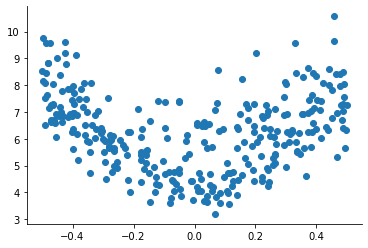

In [8]:
plt.scatter(
    mu_p_list,
    np.linalg.norm(reservoir_last_10_average, axis=1),
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

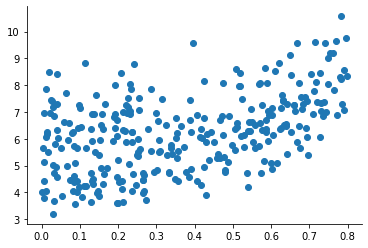

In [9]:
plt.scatter(
    sigma_p_list,
    np.linalg.norm(reservoir_last_10_average, axis=1),
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

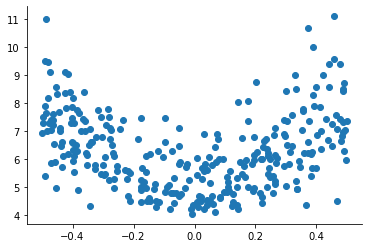

In [10]:
plt.scatter(
    mu_p_list,
    np.linalg.norm(neural_last_10_average, axis=1),
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

In [11]:
np.var(reservoir_states[:, -1, :], axis=0)

array([0.00471103, 0.86945246, 0.14579356, 0.00645075, 0.48884734,
       0.09500394, 0.35904839, 0.00519611, 0.01710788, 0.01177702,
       0.37064554, 0.43870478, 0.21039424, 0.10237892, 0.29062587,
       0.00490652, 0.32058925, 0.03777554, 0.00908985, 0.00505887,
       0.09177617, 0.00556312, 0.21588348, 0.10143163, 1.76787382,
       0.11150971, 0.03041811, 0.71631044, 0.72154595, 0.16859523,
       0.00625711, 0.06583227, 1.06711524, 0.4935789 , 1.07857885,
       0.59129831, 0.01848327, 0.20973795, 0.15756389, 1.00830691,
       0.12072168, 0.08417286, 0.43550034, 0.16494966, 0.06420613,
       0.59139511, 0.07396978, 0.005739  , 0.09884611, 0.24031541])

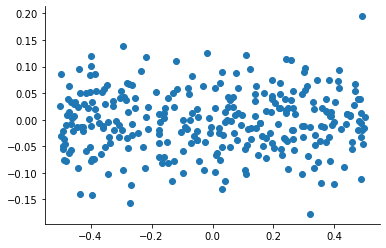

In [12]:
plt.scatter(
    mu_p_list,
    reservoir_last_10_average[:, 0],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

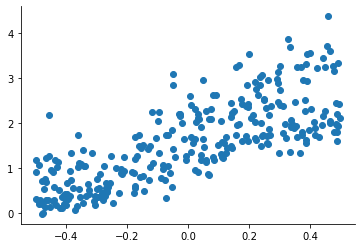

In [13]:
plt.scatter(
    mu_p_list,
    reservoir_last_10_average[:, 1],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

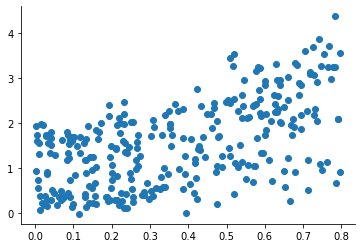

In [14]:
plt.scatter(
    sigma_p_list,
    reservoir_last_10_average[:, 1],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

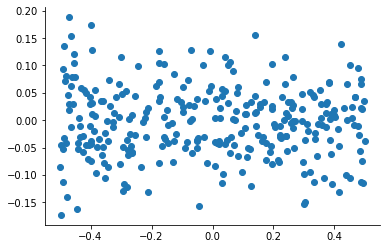

In [15]:
plt.scatter(
    mu_p_list,
    reservoir_last_10_average[:, 7],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

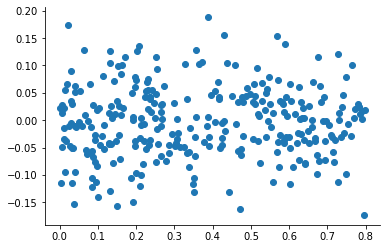

In [16]:
plt.scatter(
    sigma_p_list,
    reservoir_last_10_average[:, 7],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

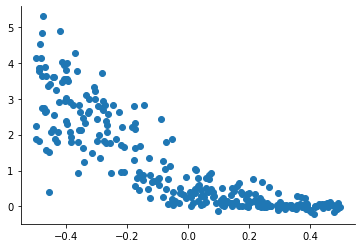

In [17]:
plt.scatter(
    mu_p_list,
    reservoir_last_10_average[:, 24],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

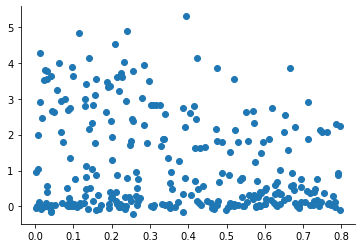

In [18]:
plt.scatter(
    sigma_p_list,
    reservoir_last_10_average[:, 24],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

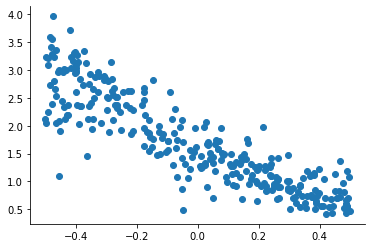

In [19]:
plt.scatter(
    mu_p_list,
    reservoir_last_10_average[:, 27],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

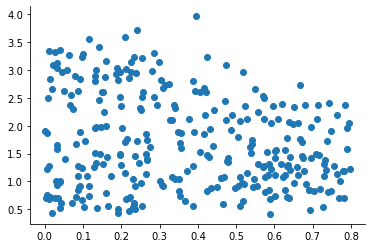

In [20]:
plt.scatter(
    sigma_p_list,
    reservoir_last_10_average[:, 27],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

0


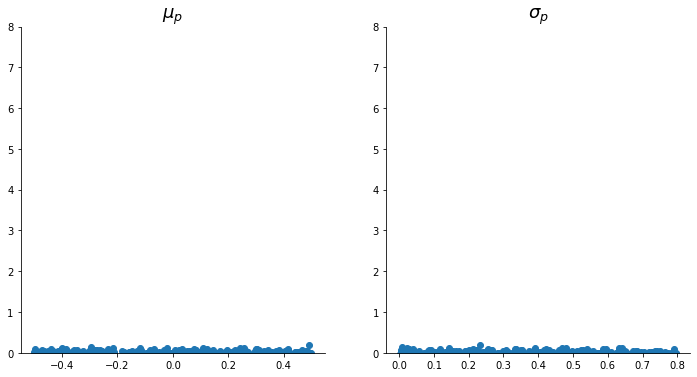

1


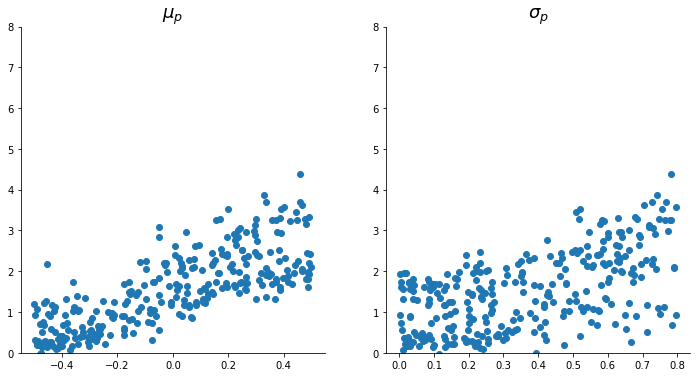

2


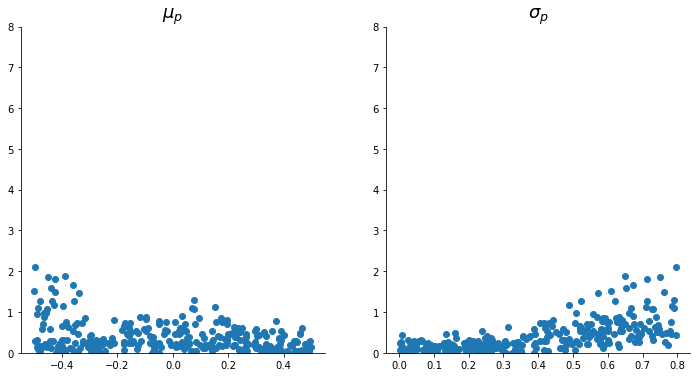

3


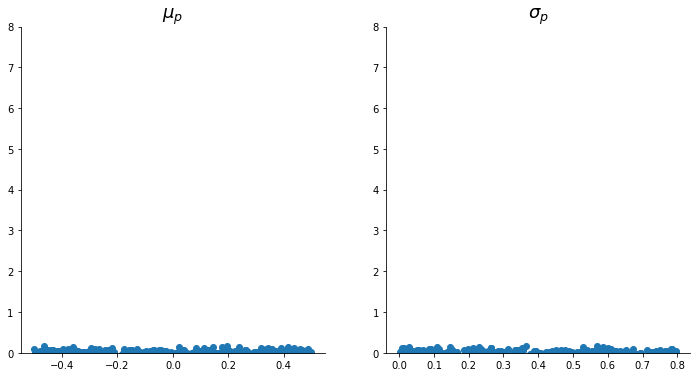

4


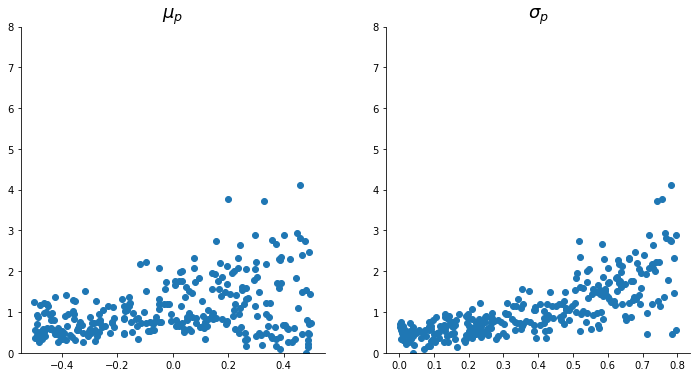

5


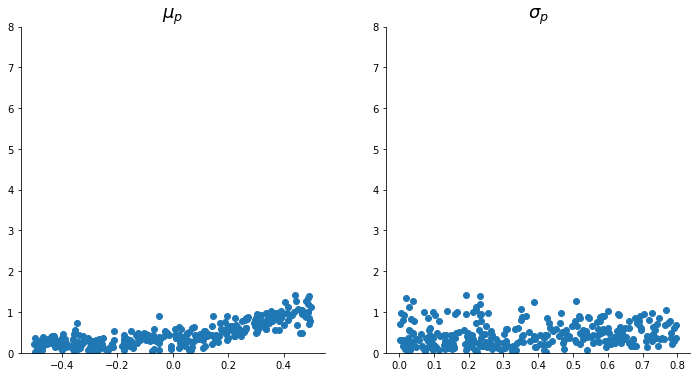

6


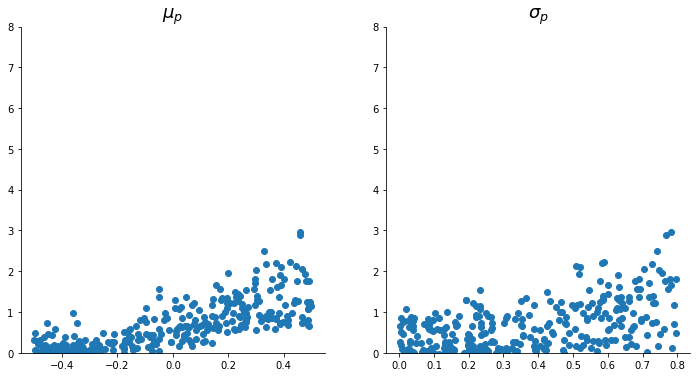

7


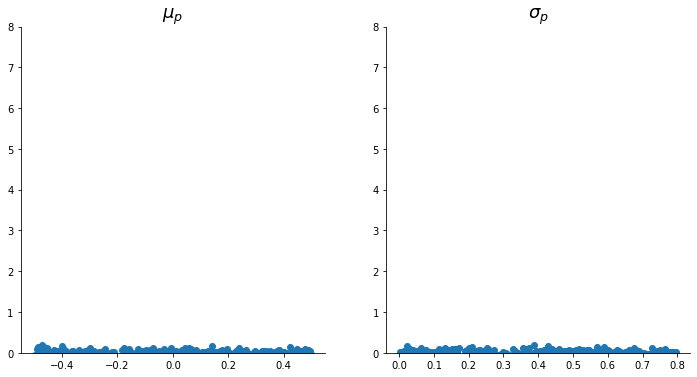

8


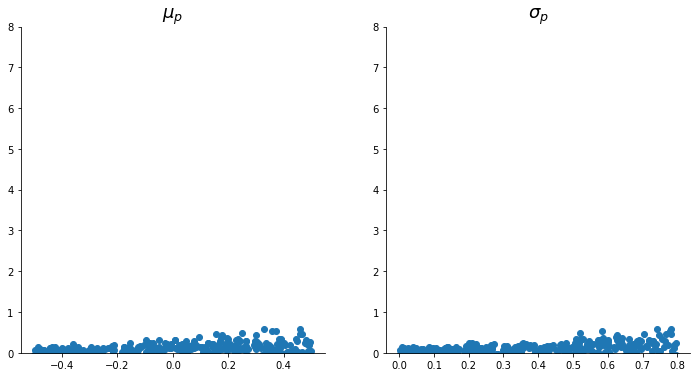

9


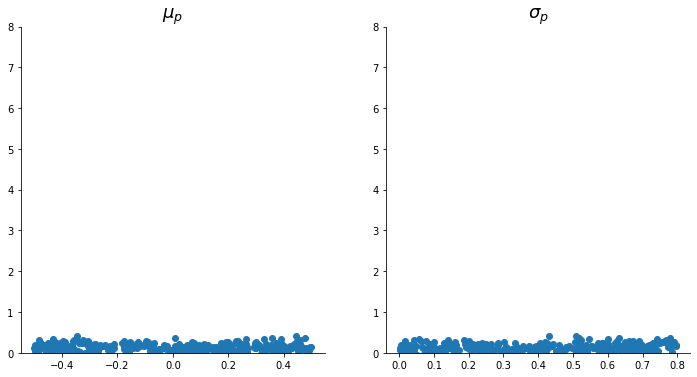

10


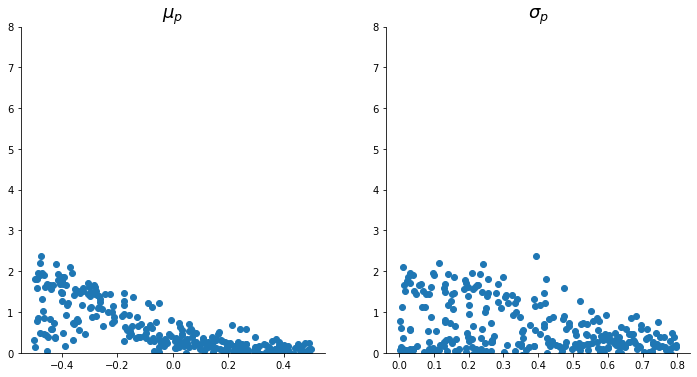

11


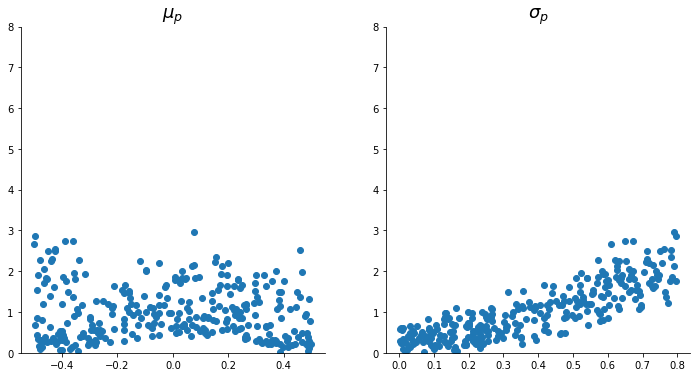

12


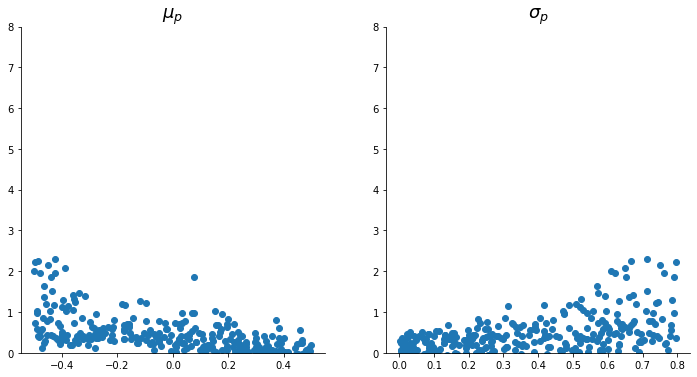

13


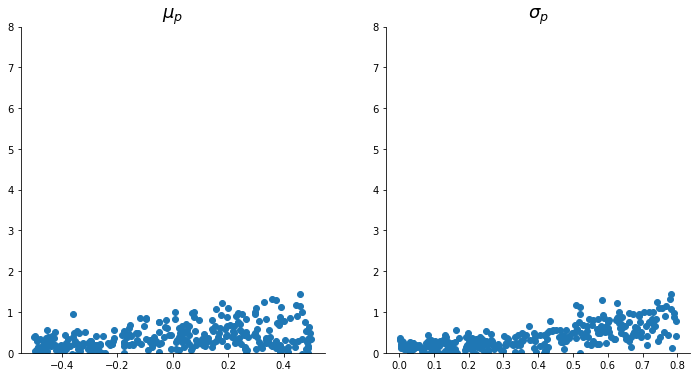

14


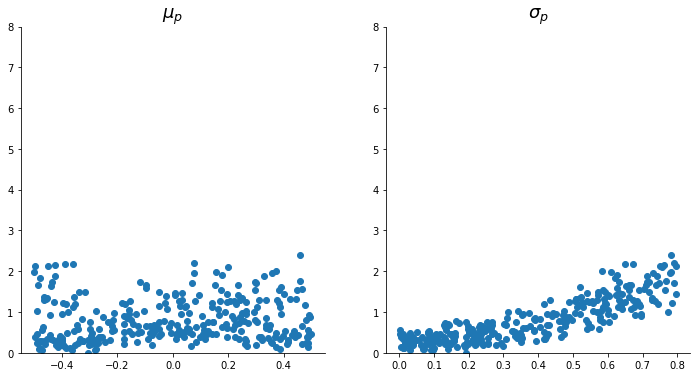

15


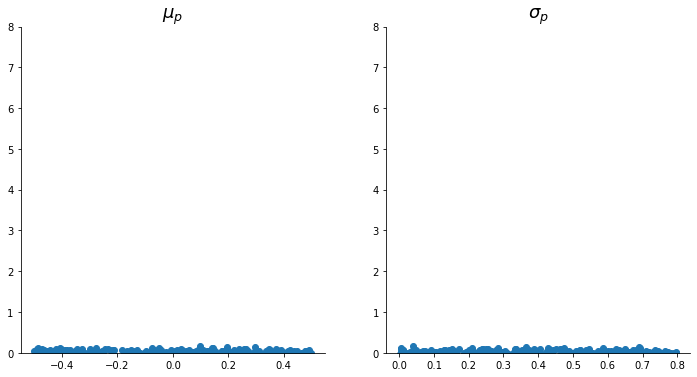

16


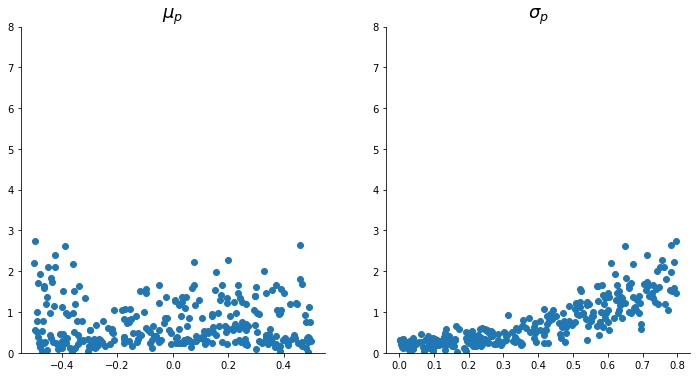

17


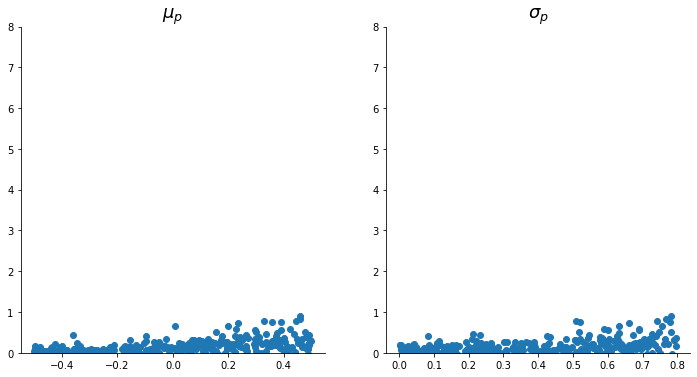

18


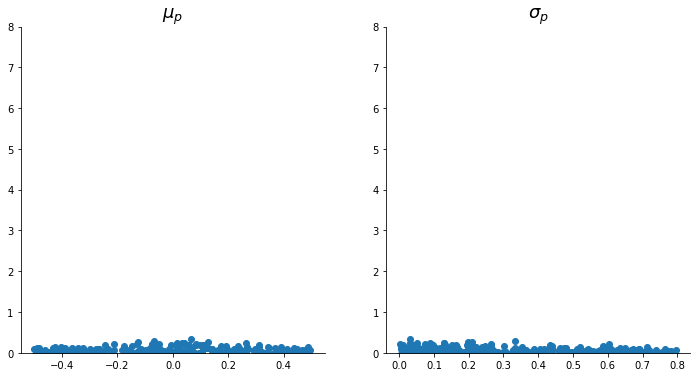

19


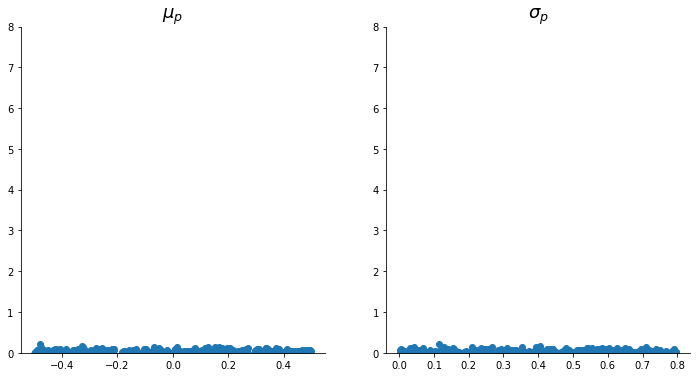

20


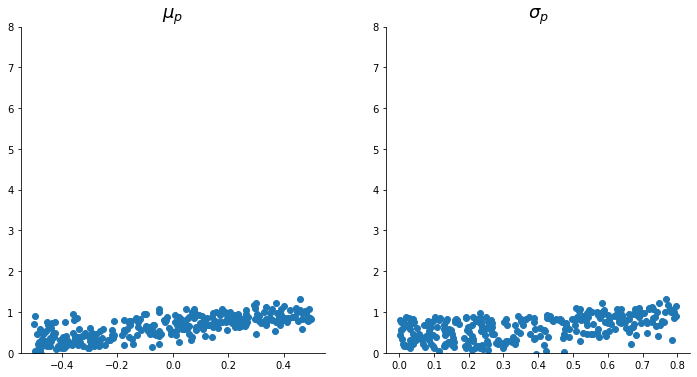

21


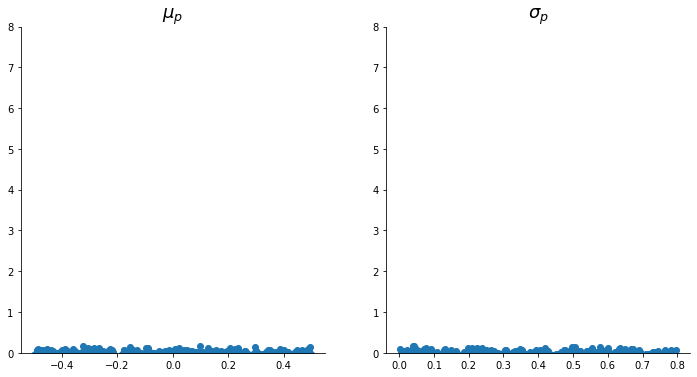

22


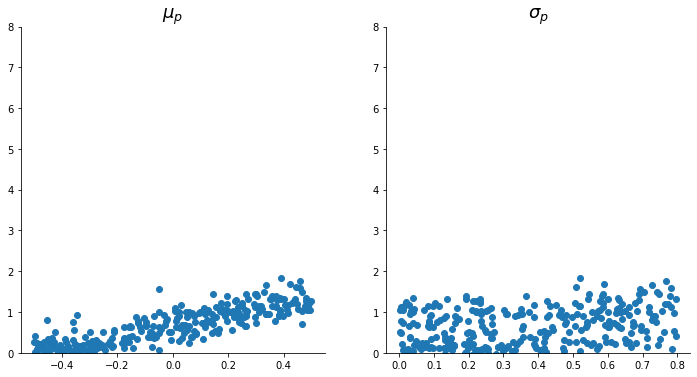

23


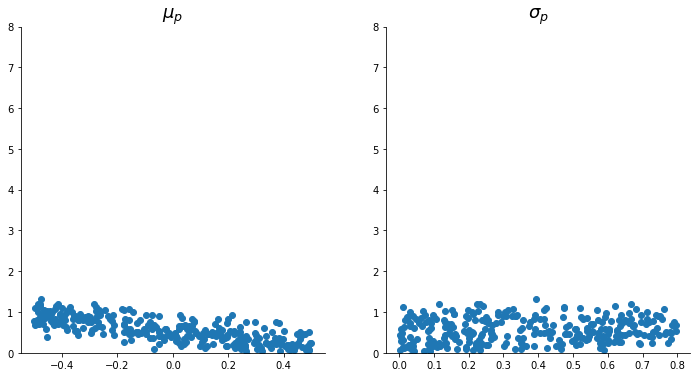

24


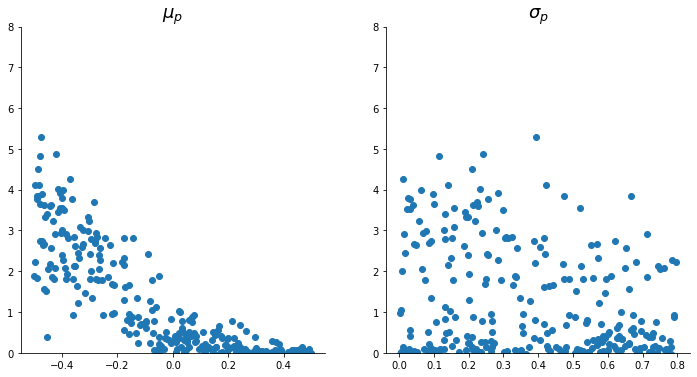

25


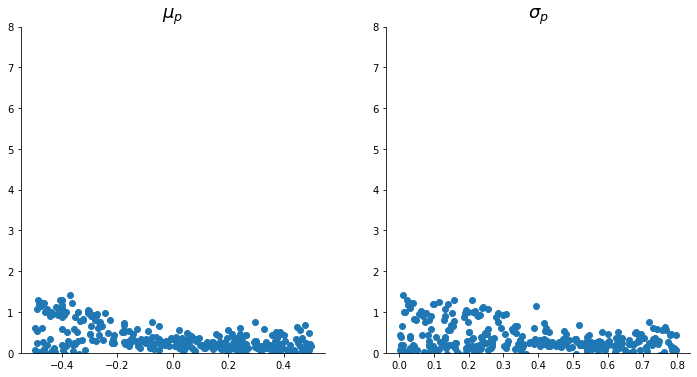

26


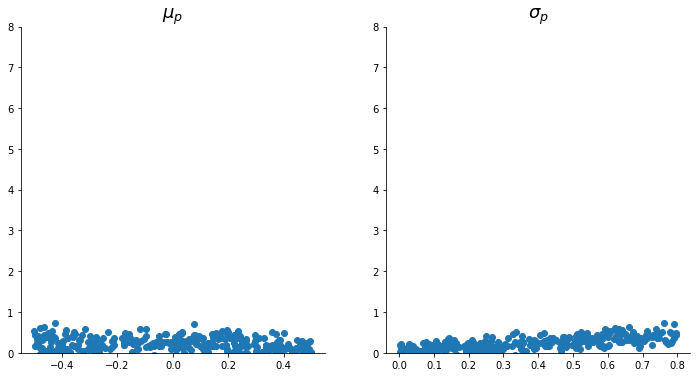

27


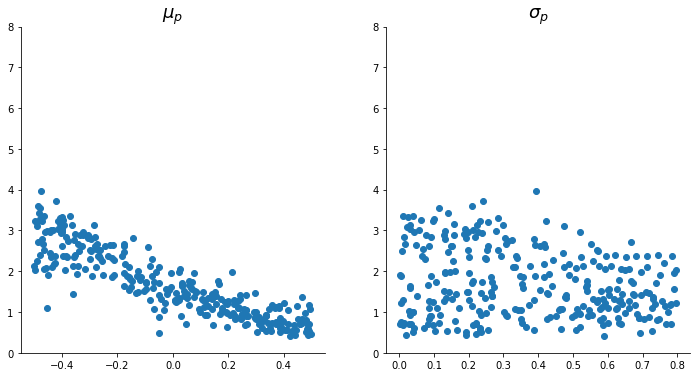

28


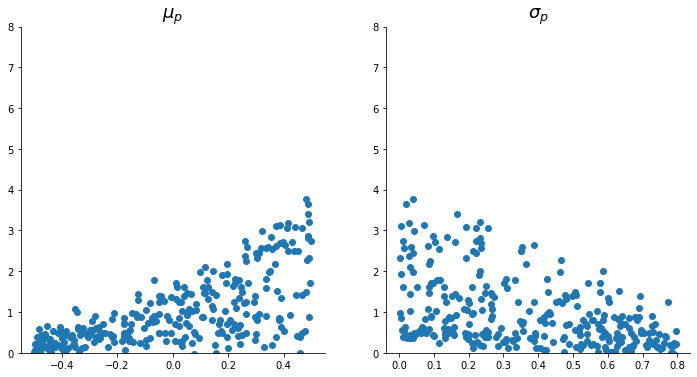

29


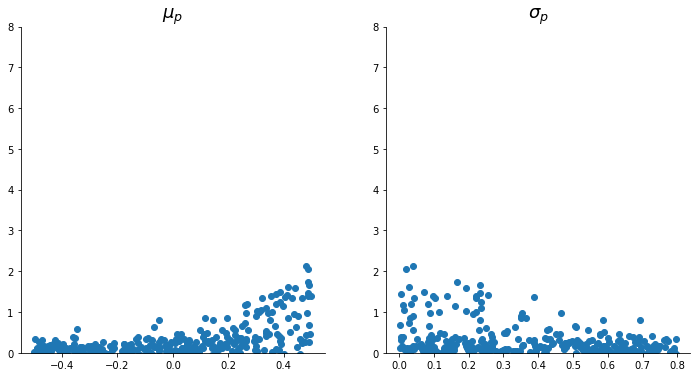

30


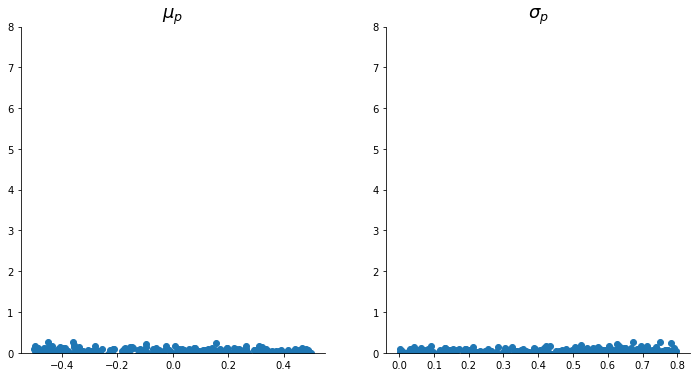

31


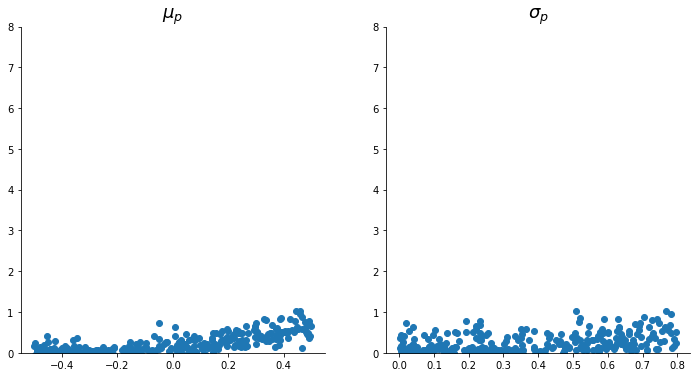

32


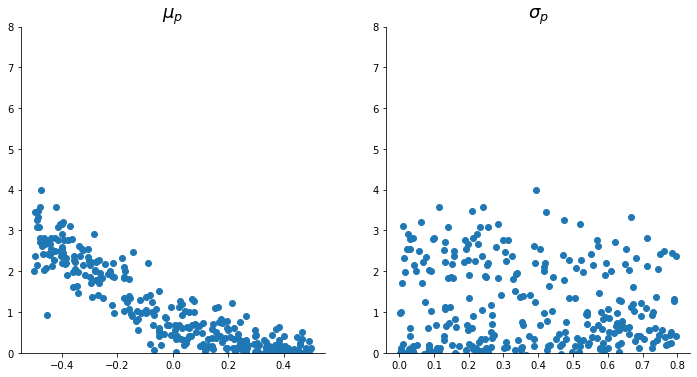

33


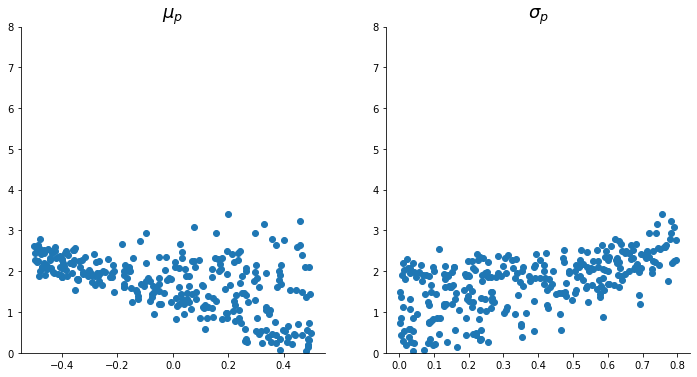

34


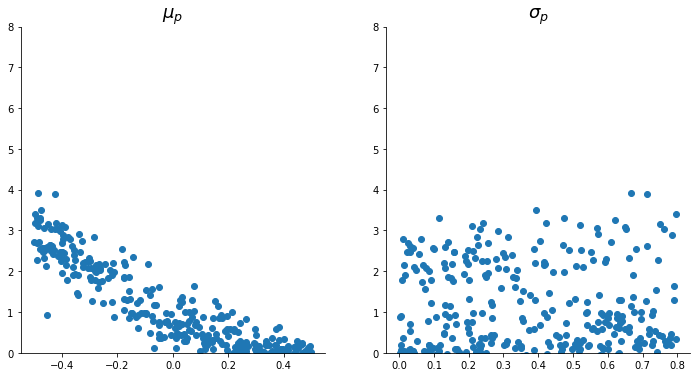

35


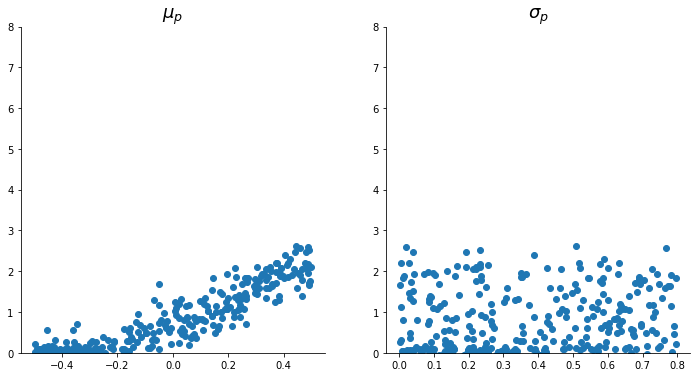

36


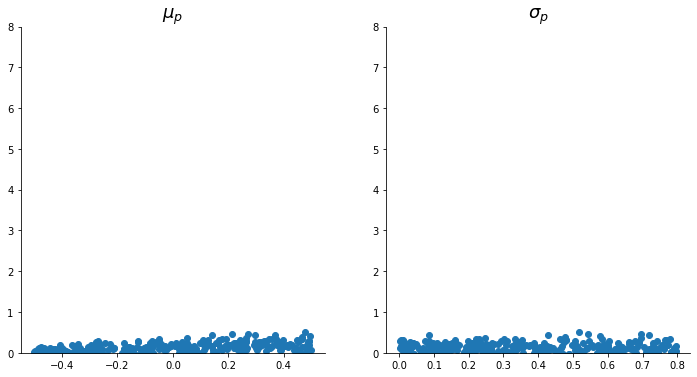

37


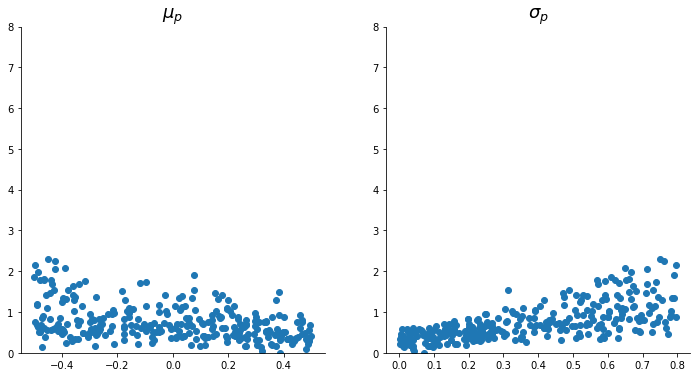

38


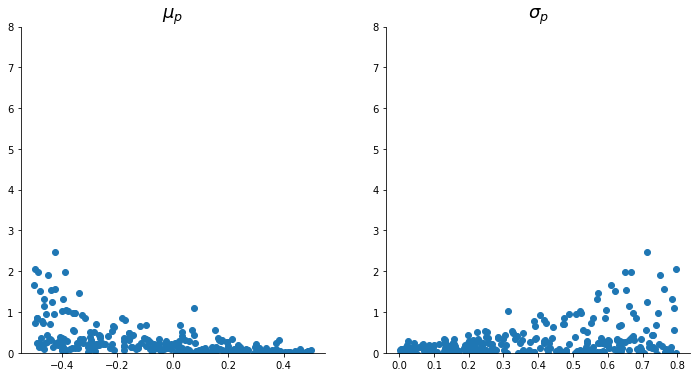

39


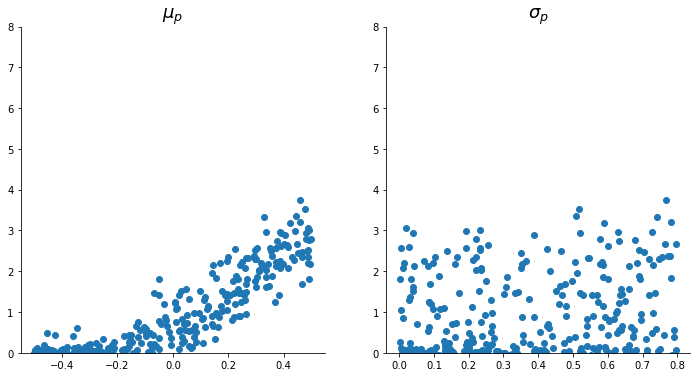

40


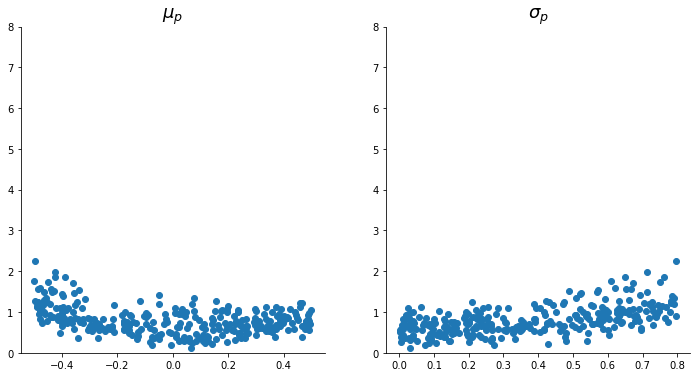

41


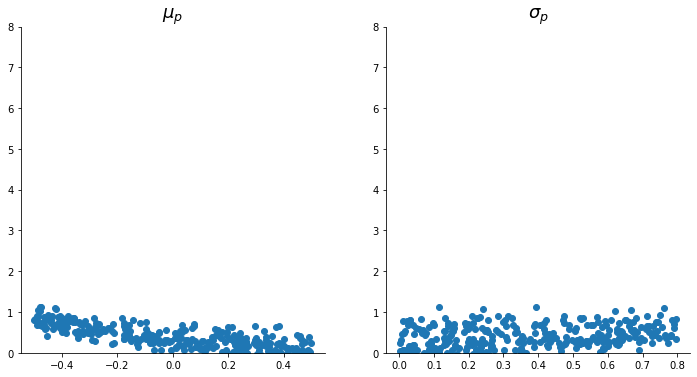

42


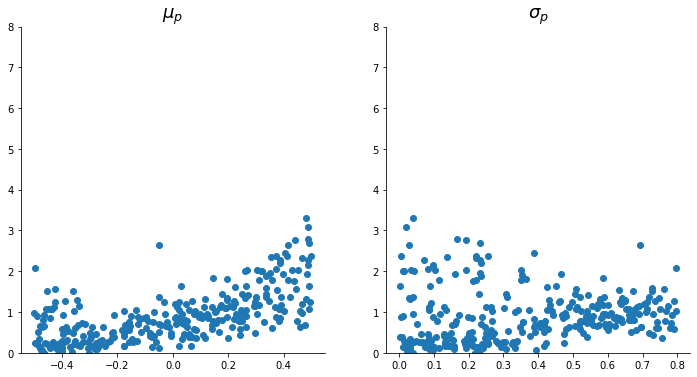

43


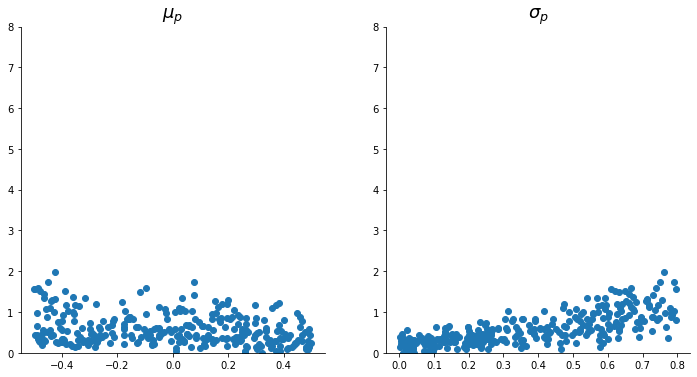

44


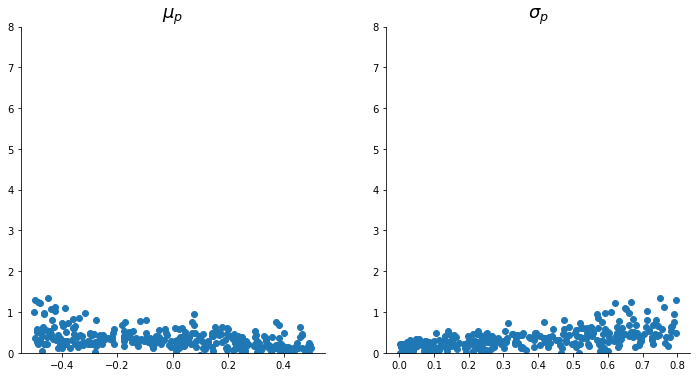

45


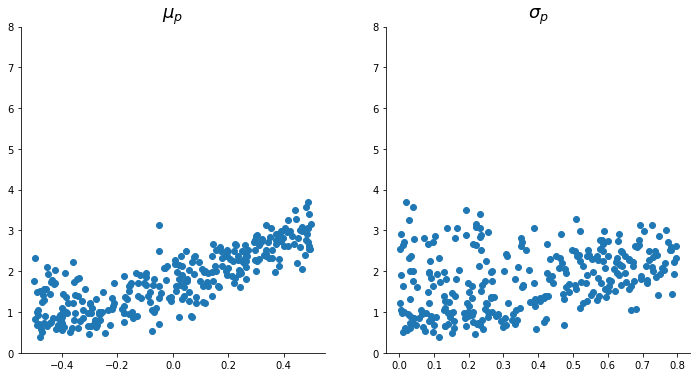

46


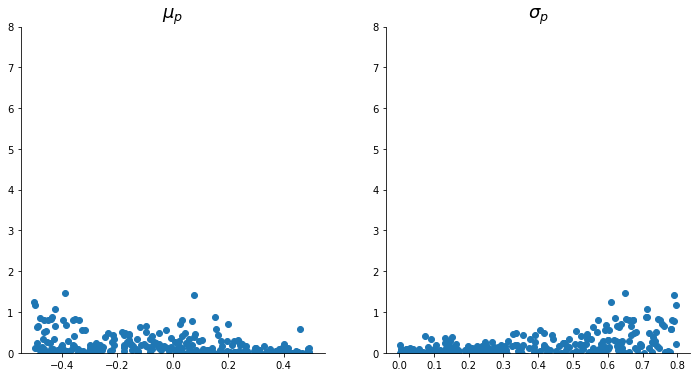

47


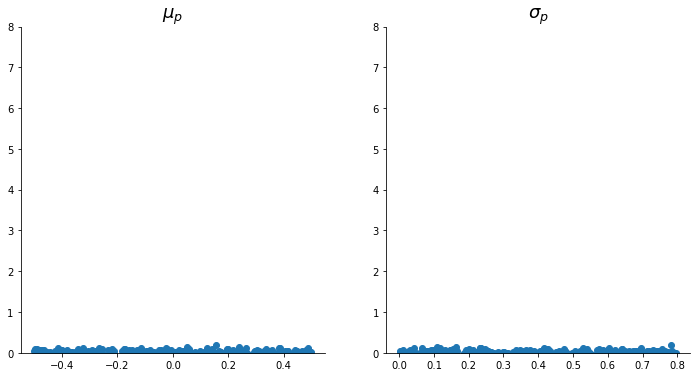

48


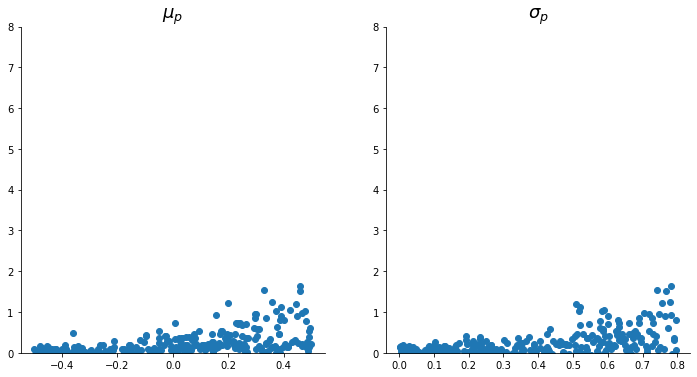

49


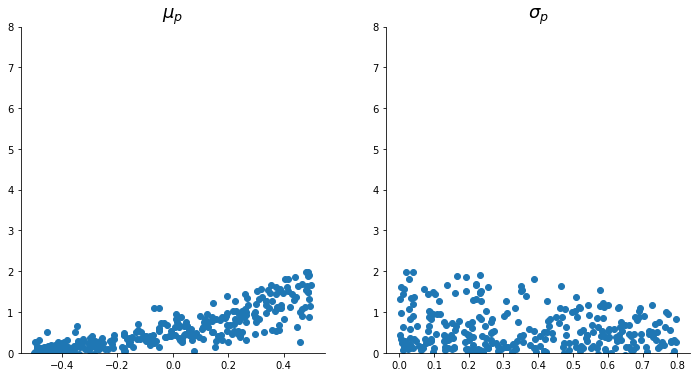

In [21]:
for i in range(50):
    print(i)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(
        mu_p_list,
        reservoir_last_10_average[:, i],
    )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.ylim([0, 8])
    plt.title(r'$\mu_p$', fontsize=18)
    
    plt.subplot(1, 2, 2)
    plt.scatter(
        sigma_p_list,
        reservoir_last_10_average[:, i],
    )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.title(r'$\sigma_p$', fontsize=18)
    plt.ylim([0, 8])
    plt.show()

Text(0.5, 0, '$y$')

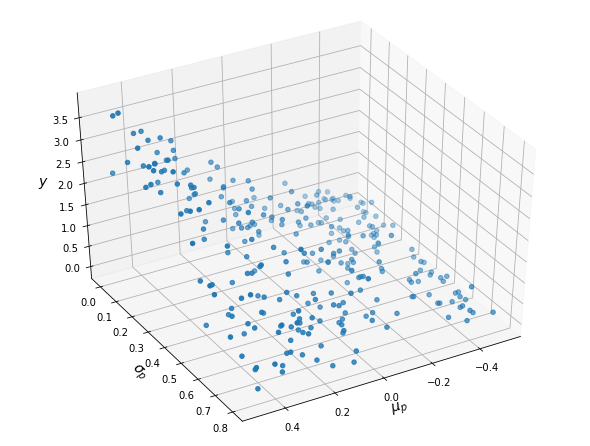

In [31]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=40, azim=60)

ax.scatter(
    mu_p_list,
    sigma_p_list,
    reservoir_last_10_average[:, 28],
)

ax.set_xlabel(r'$\mu_p$', fontsize=14)
ax.set_ylabel(r'$\sigma_p$', fontsize=14)
ax.set_zlabel(r'$y$', fontsize=14)

Text(0.5, 0, '$y$')

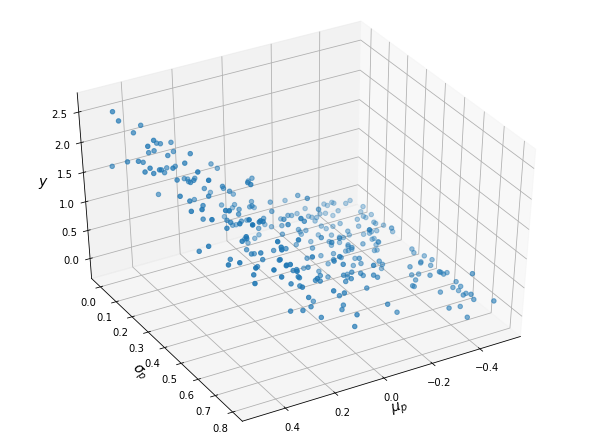

In [30]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=40, azim=60)

ax.scatter(
    mu_p_list,
    sigma_p_list,
    reservoir_last_10_average[:, 35],
)

ax.set_xlabel(r'$\mu_p$', fontsize=14)
ax.set_ylabel(r'$\sigma_p$', fontsize=14)
ax.set_zlabel(r'$y$', fontsize=14)

Text(0.5, 0, '$y$')

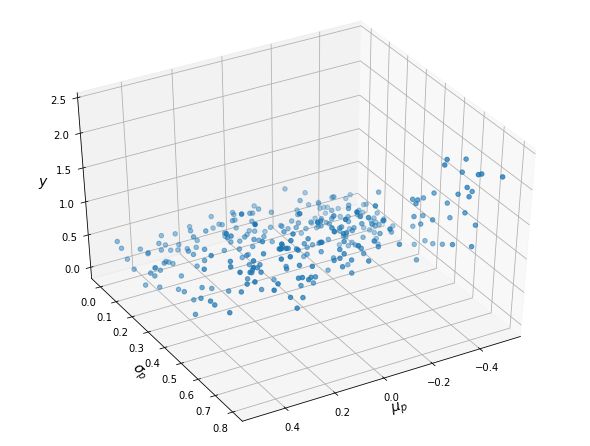

In [29]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=40, azim=60)

ax.scatter(
    mu_p_list,
    sigma_p_list,
    reservoir_last_10_average[:, 14],
)

ax.set_xlabel(r'$\mu_p$', fontsize=14)
ax.set_ylabel(r'$\sigma_p$', fontsize=14)
ax.set_zlabel(r'$y$', fontsize=14)

0


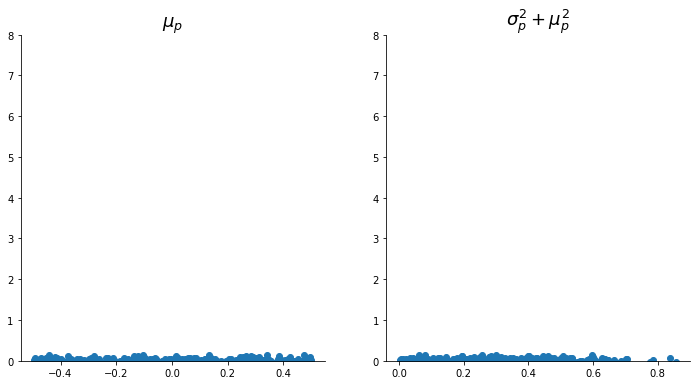

1


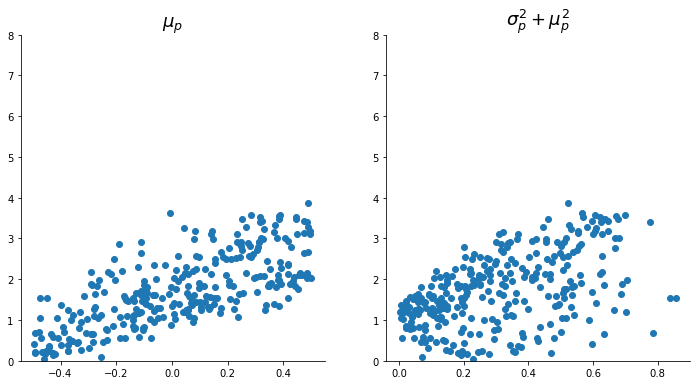

2


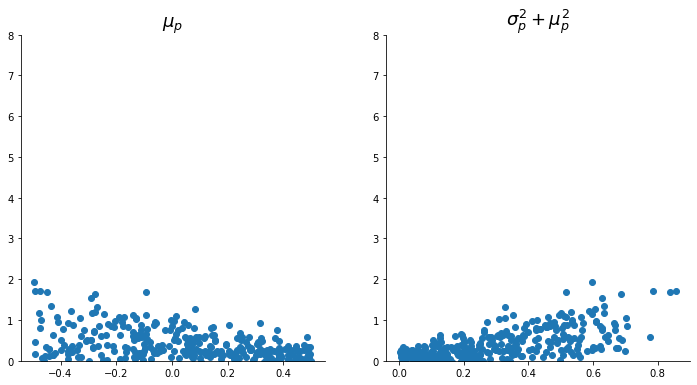

3


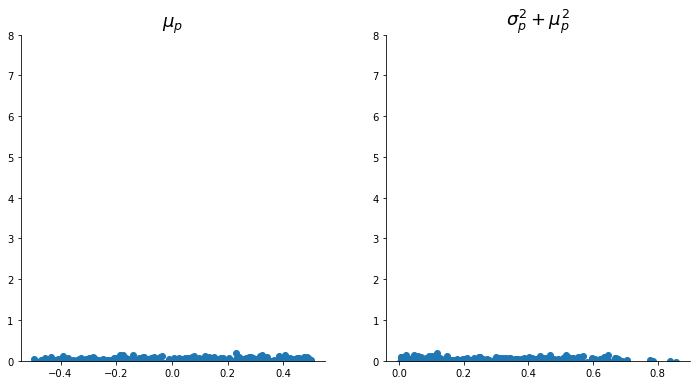

4


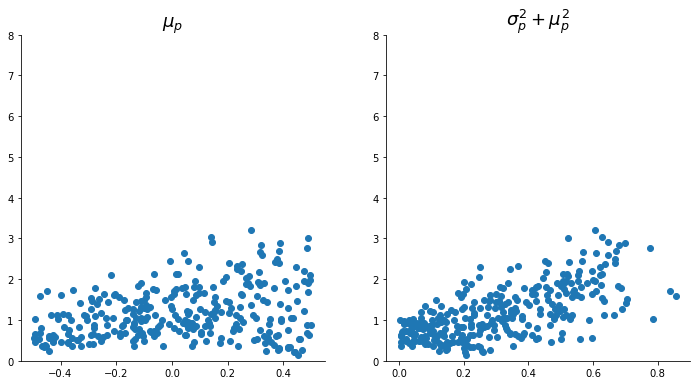

5


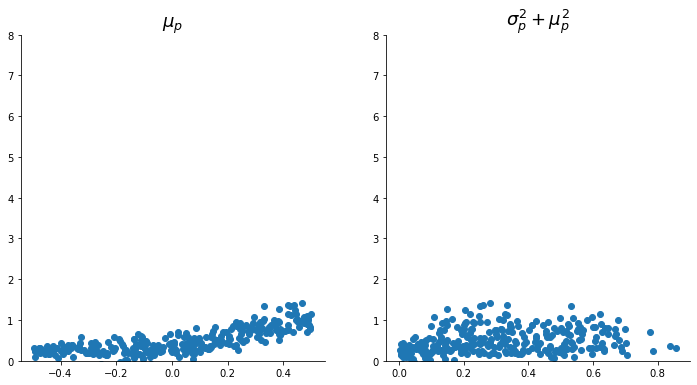

6


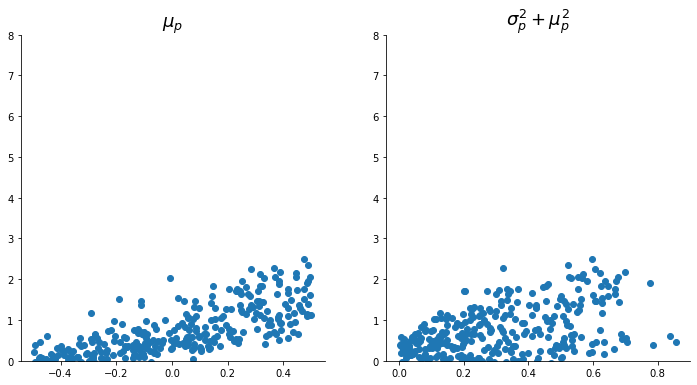

7


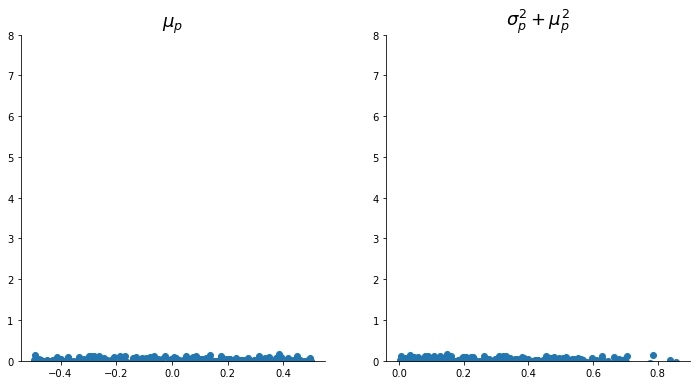

8


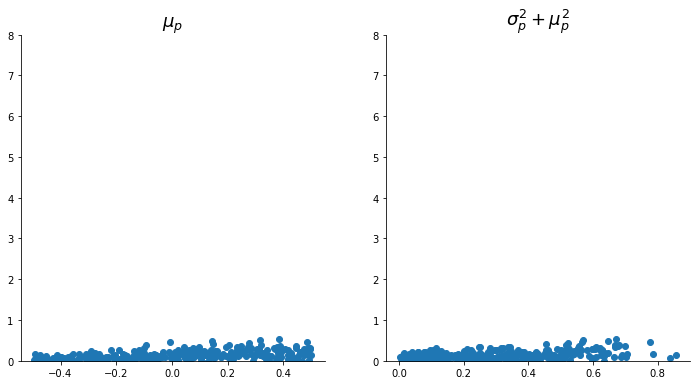

9


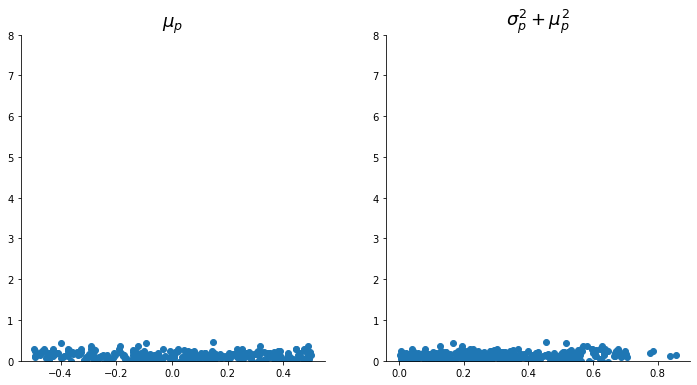

10


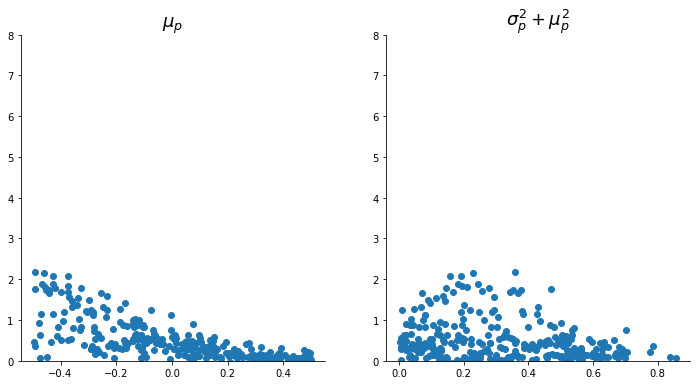

11


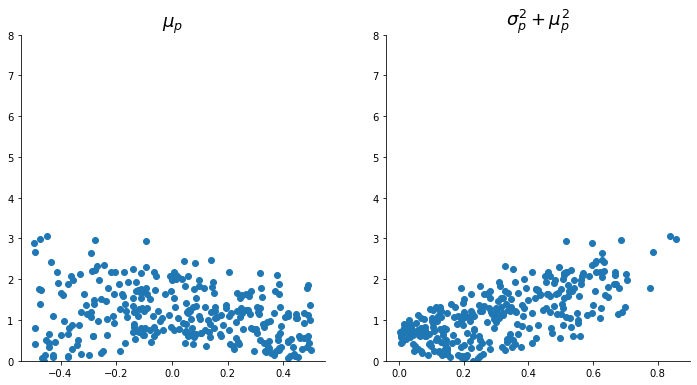

12


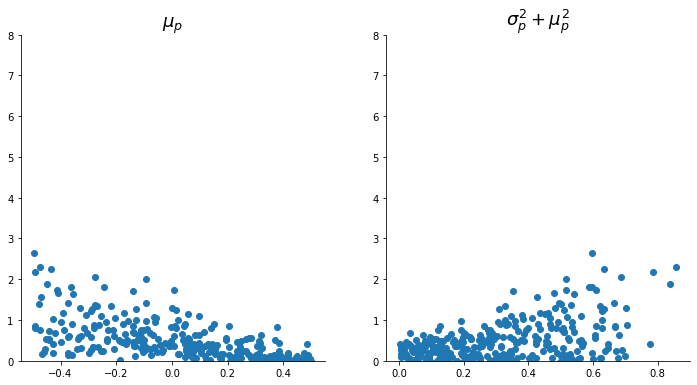

13


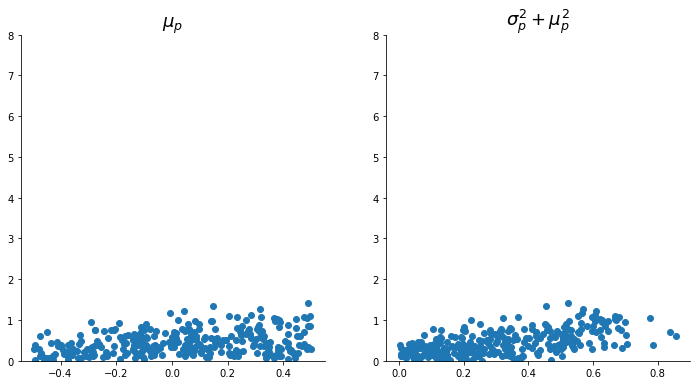

14


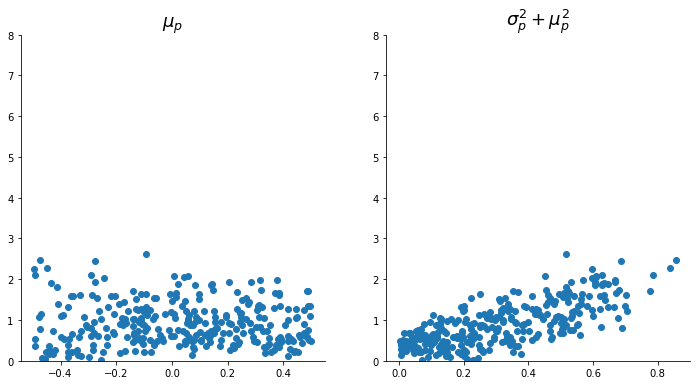

15


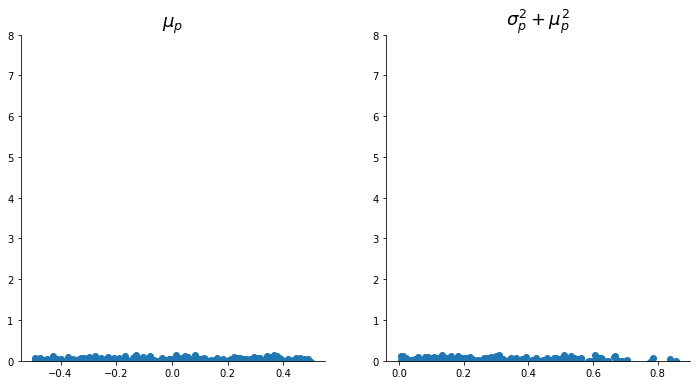

16


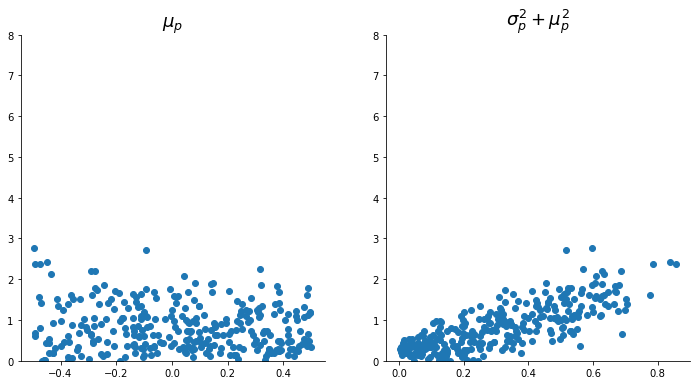

17


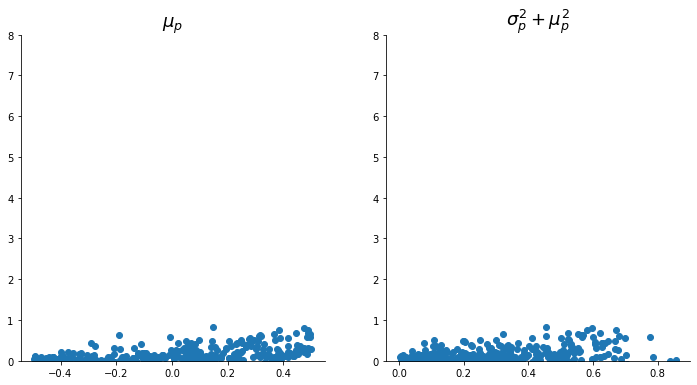

18


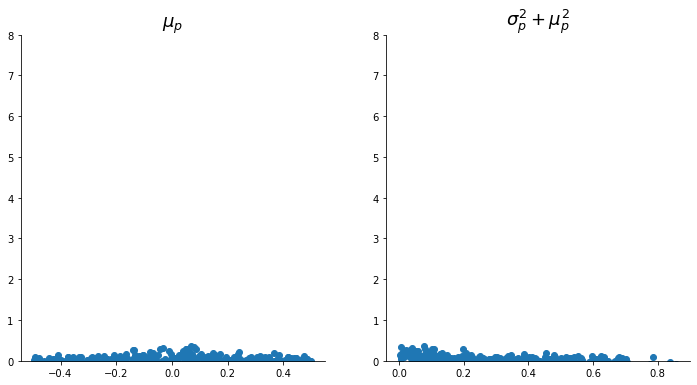

19


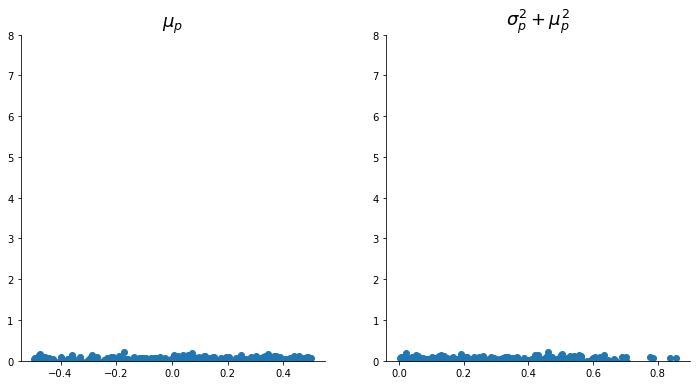

20


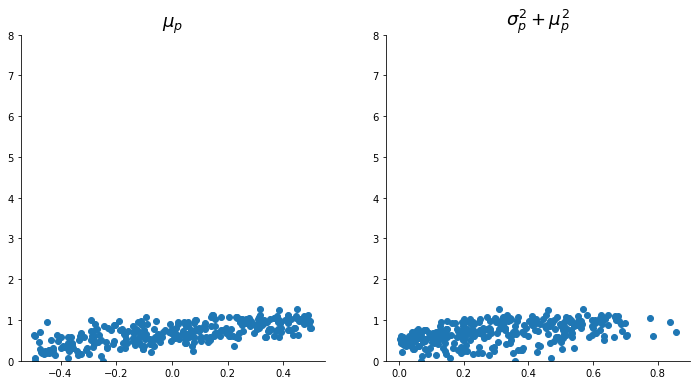

21


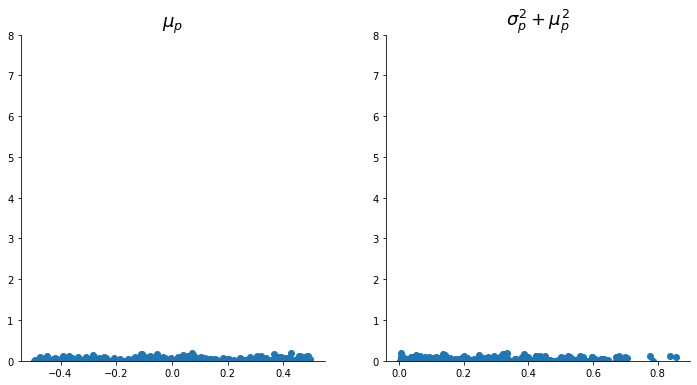

22


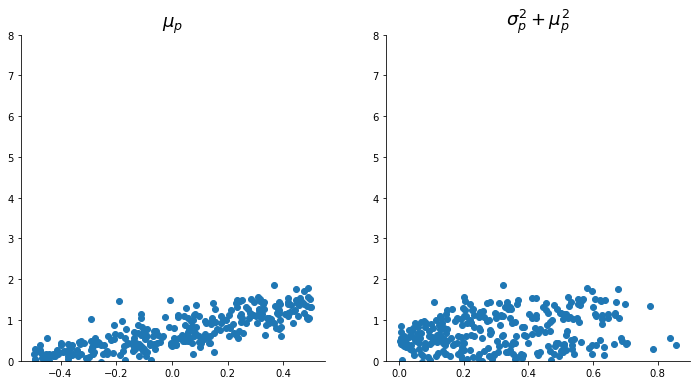

23


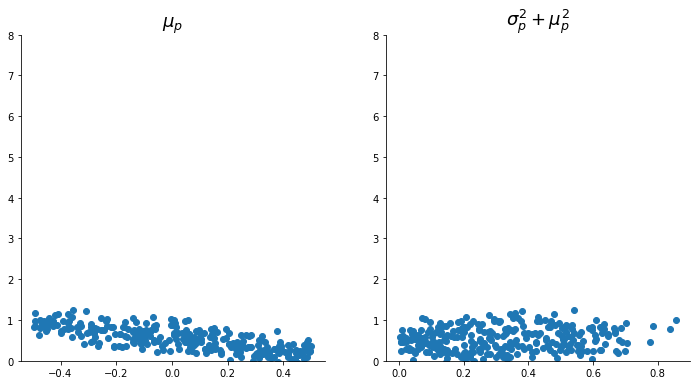

24


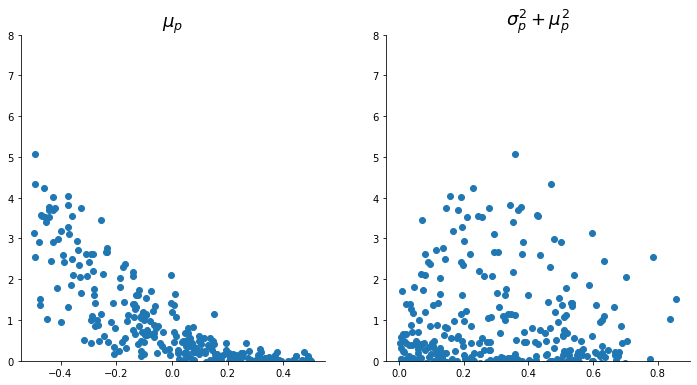

25


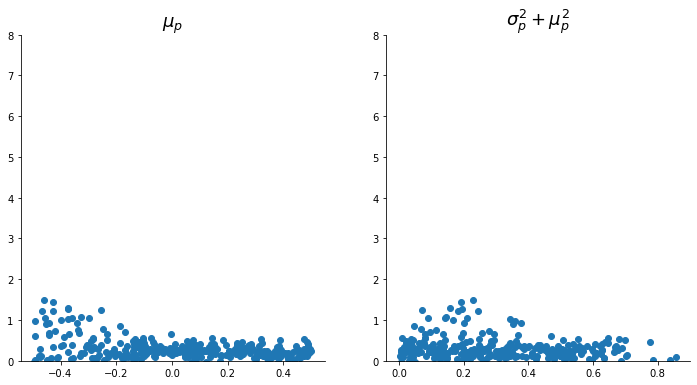

26


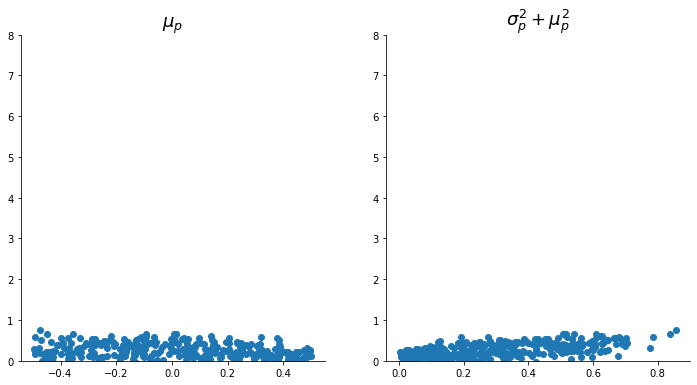

27


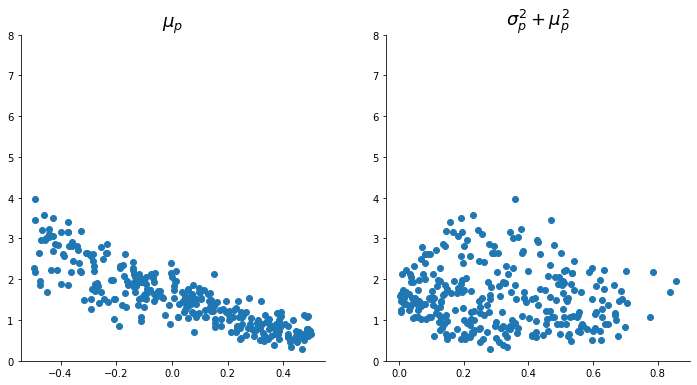

28


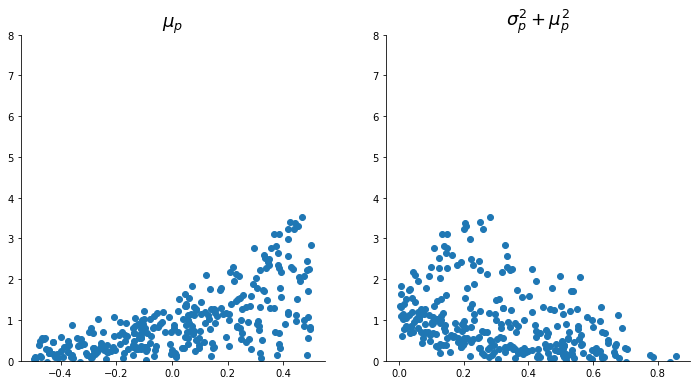

29


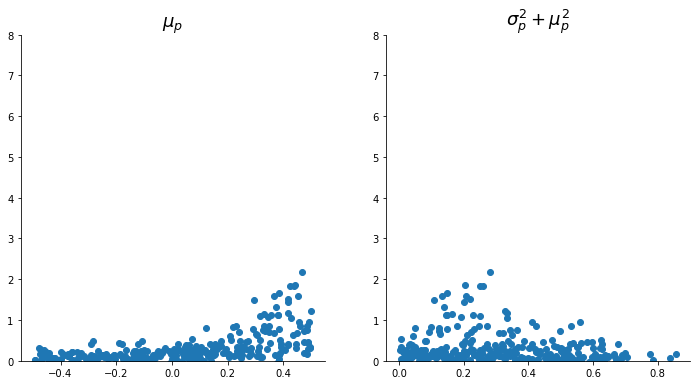

30


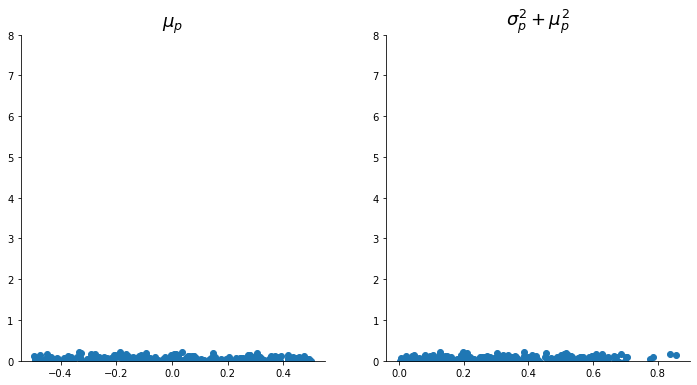

31


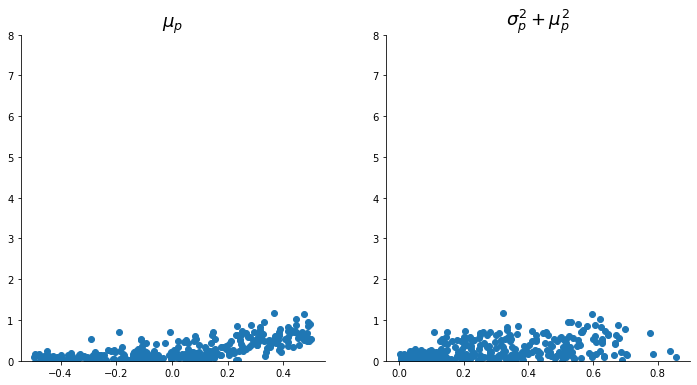

32


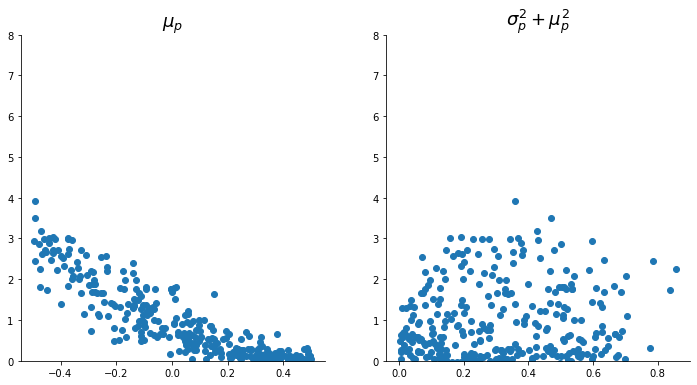

33


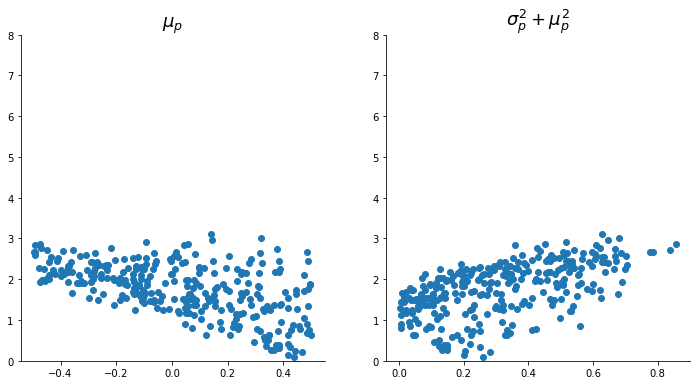

34


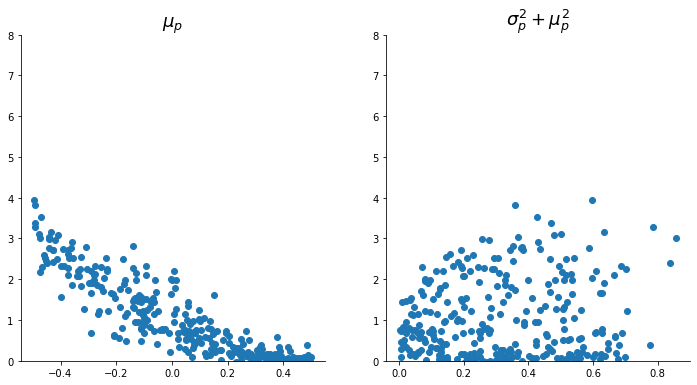

35


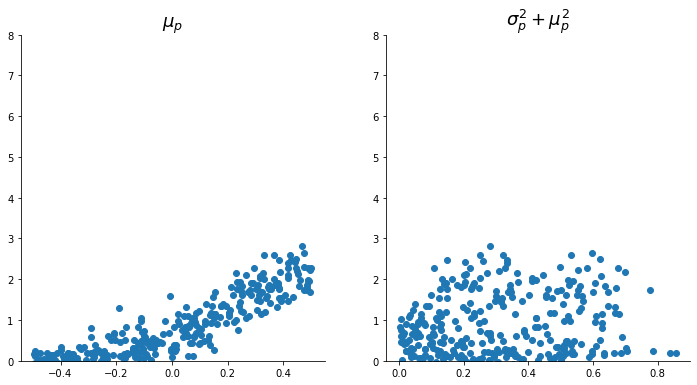

36


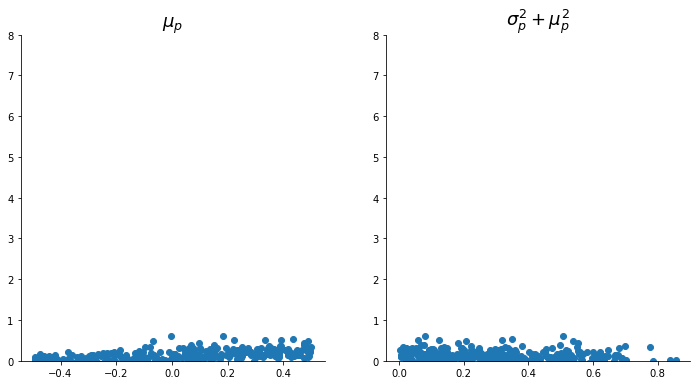

37


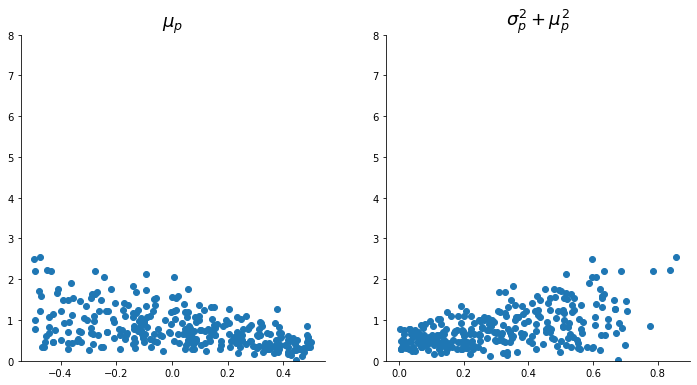

38


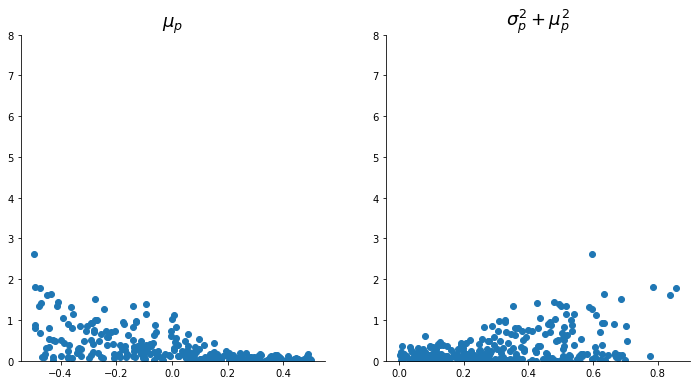

39


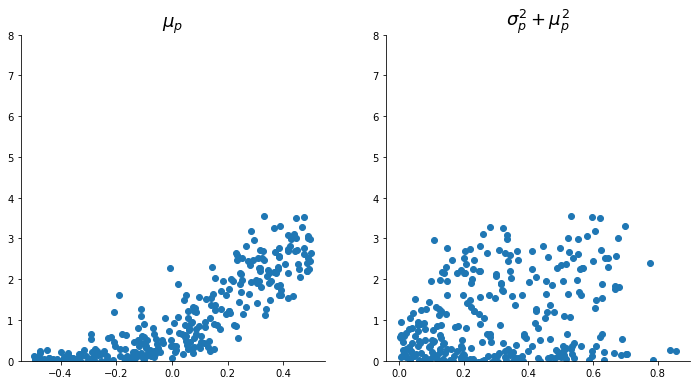

40


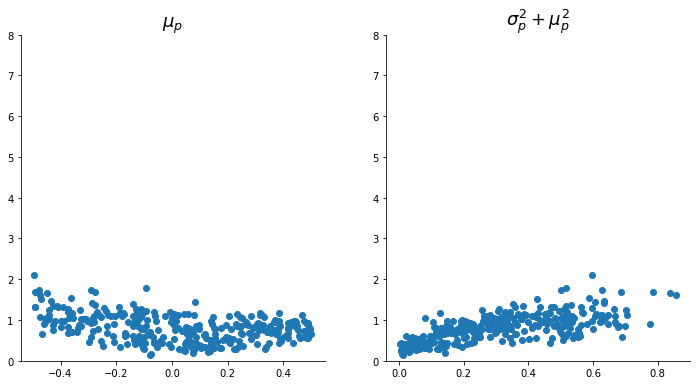

41


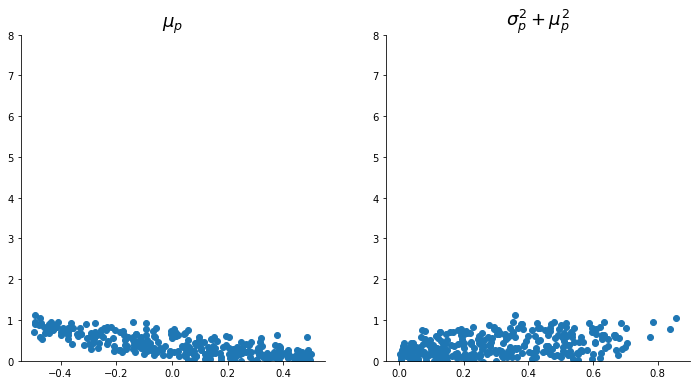

42


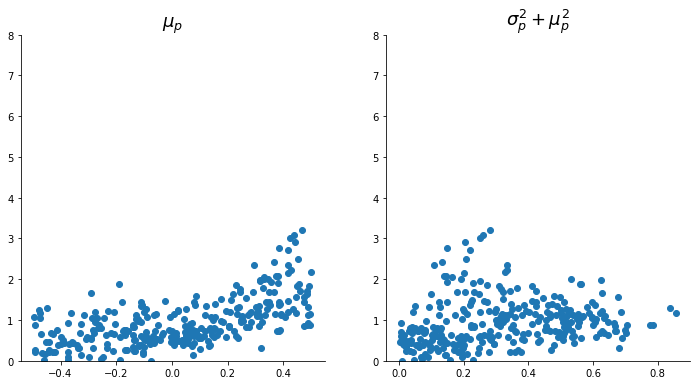

43


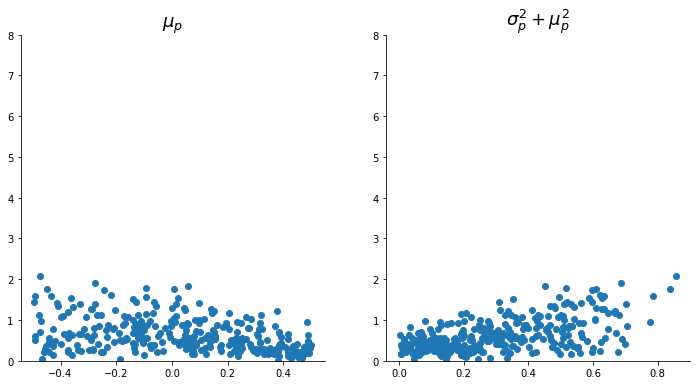

44


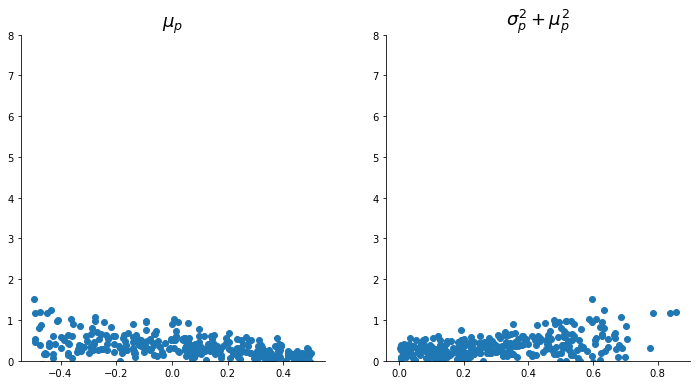

45


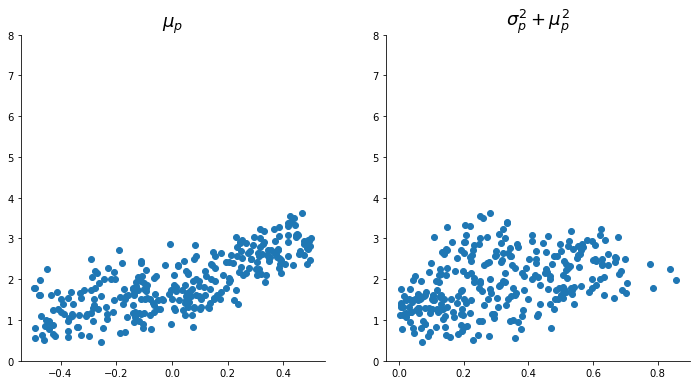

46


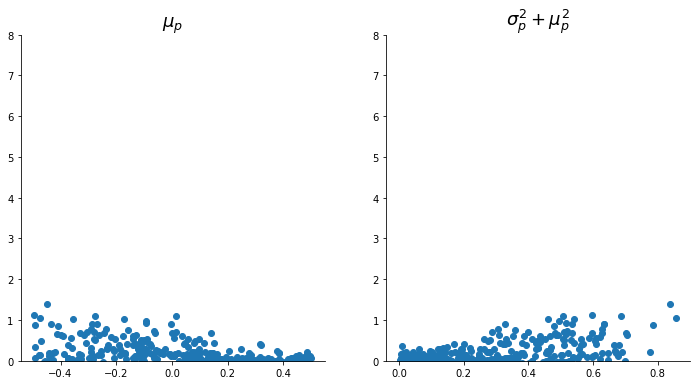

47


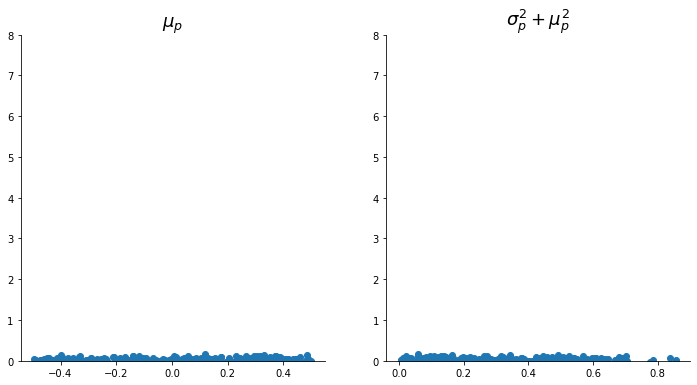

48


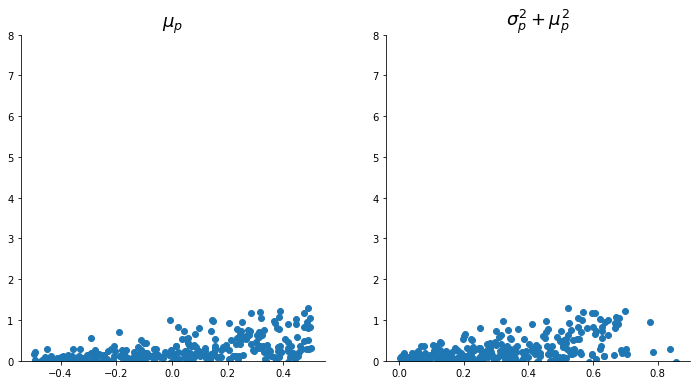

49


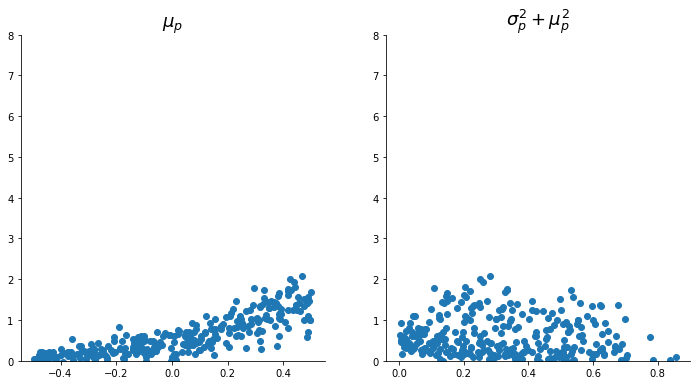

In [24]:
for i in range(50):
    print(i)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(
        mu_p_list,
        reservoir_last_10_average[:, i],
    )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.ylim([0, 8])
    plt.title(r'$\mu_p$', fontsize=18)
    
    plt.subplot(1, 2, 2)
    plt.scatter(
        np.array(sigma_p_list)**2+np.array(mu_p_list)**2,
        reservoir_last_10_average[:, i],
    )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.title(r'$\sigma_p^2+\mu_p^2$', fontsize=18)
    plt.ylim([0, 8])
    plt.show()

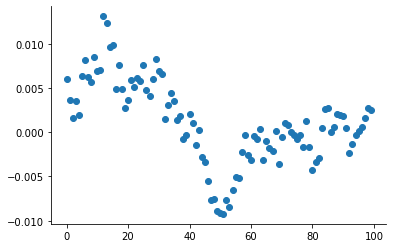

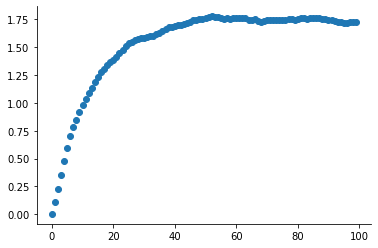

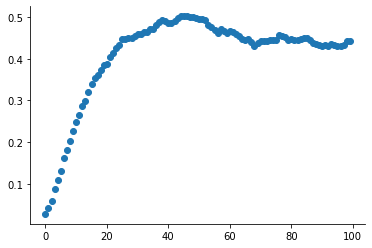

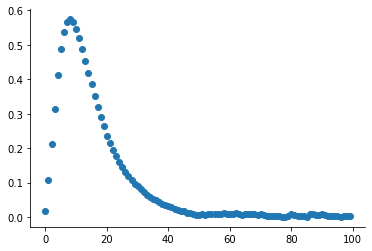

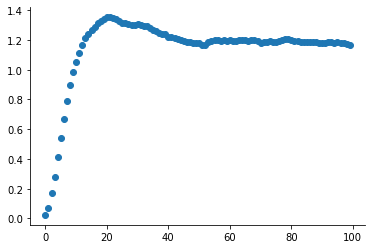

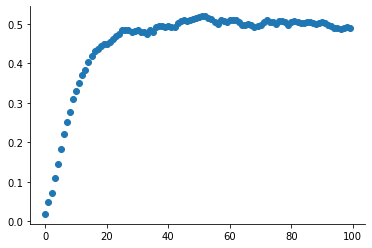

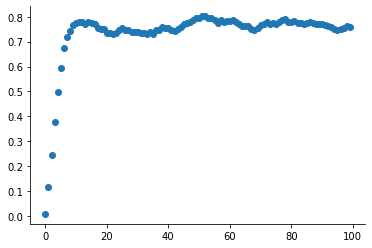

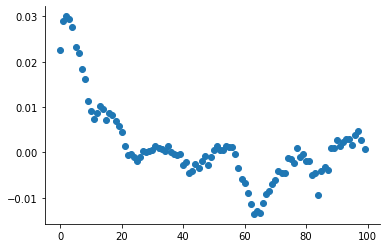

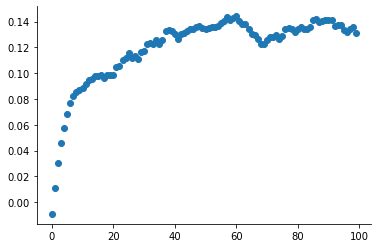

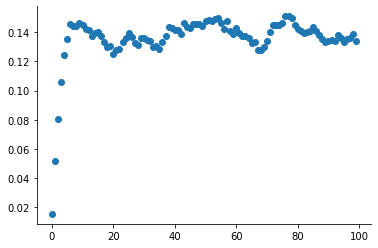

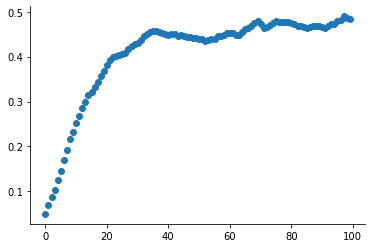

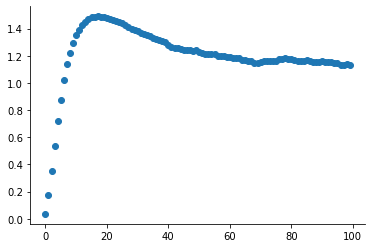

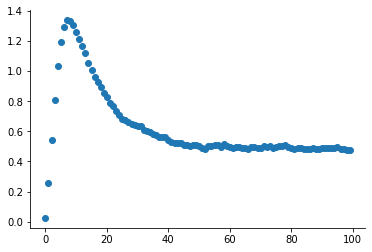

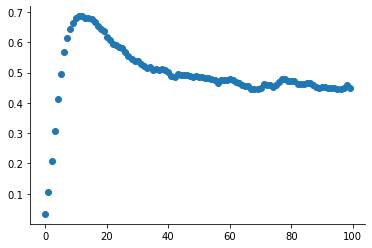

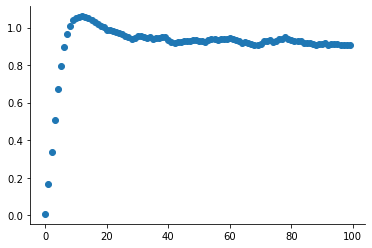

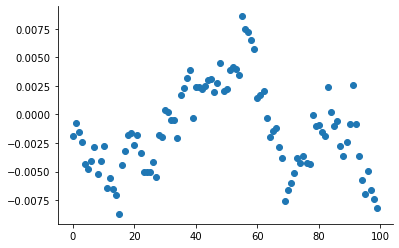

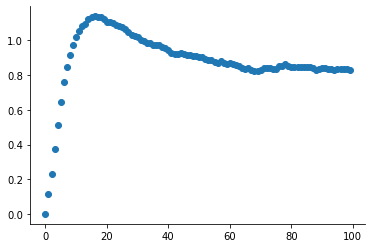

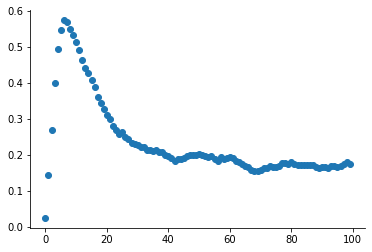

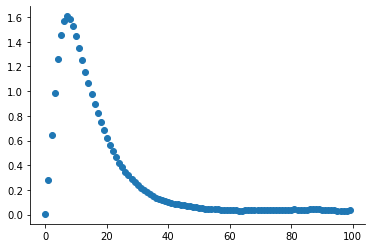

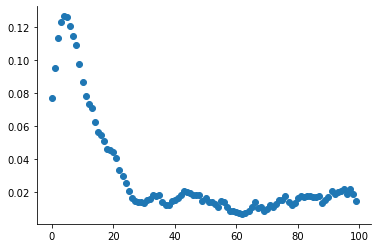

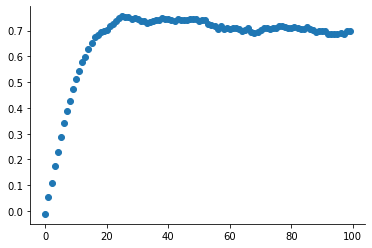

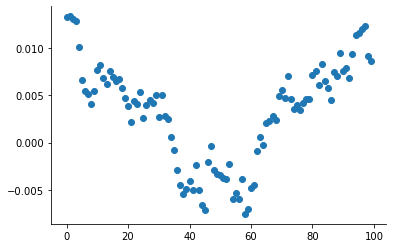

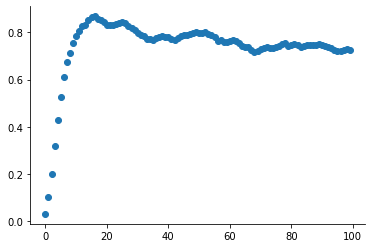

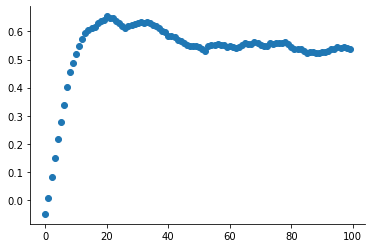

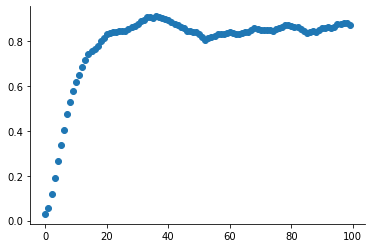

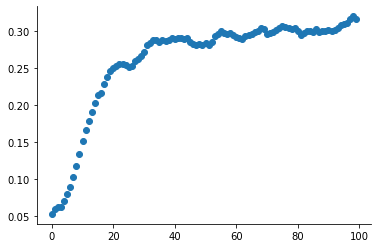

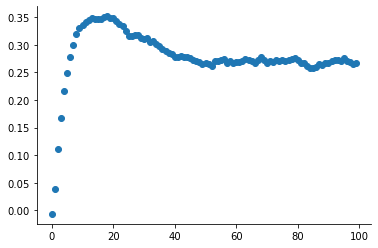

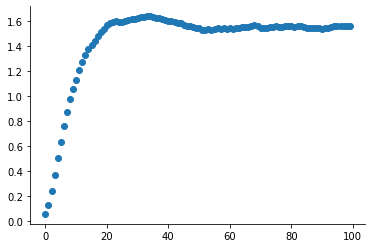

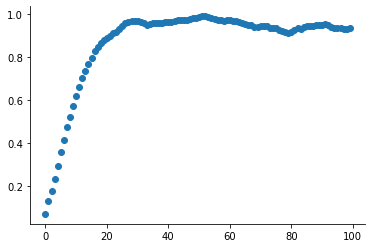

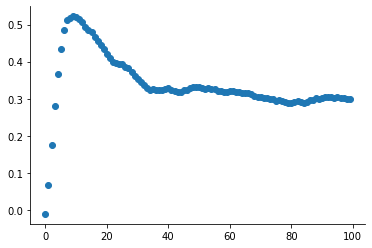

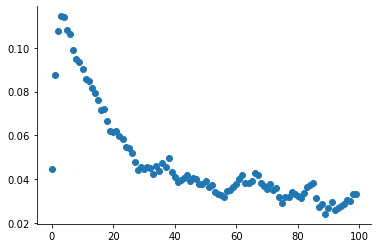

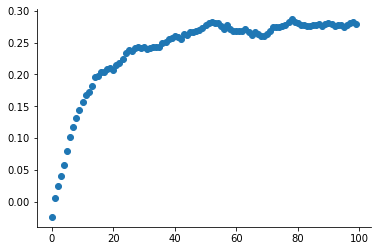

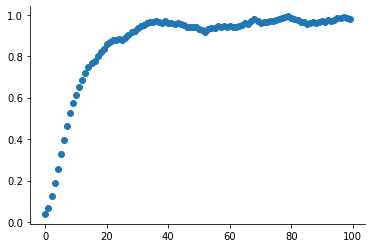

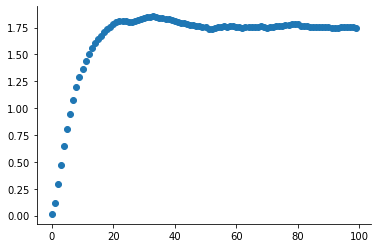

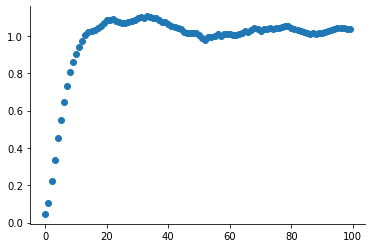

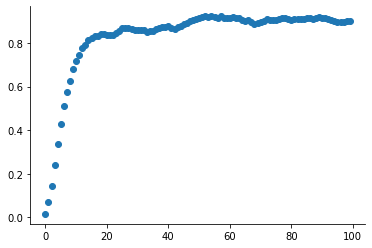

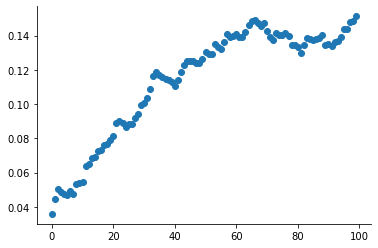

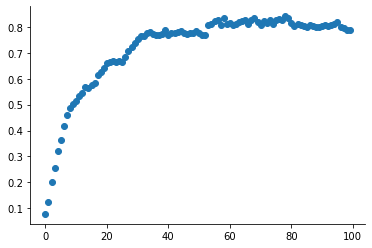

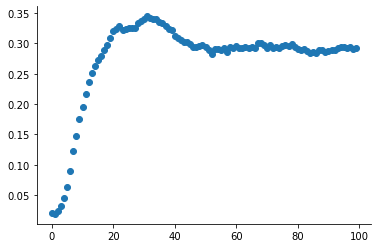

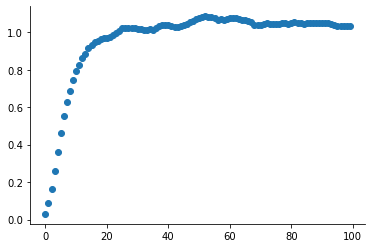

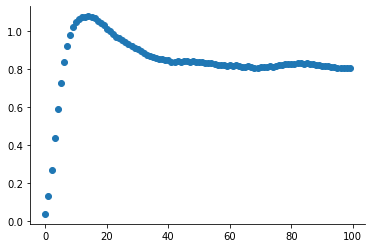

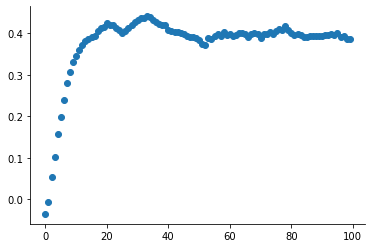

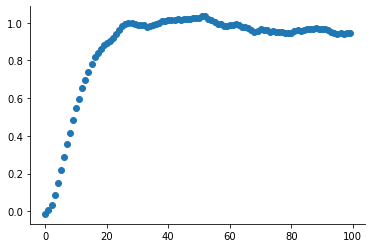

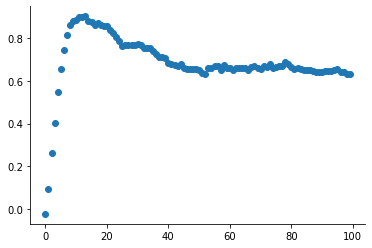

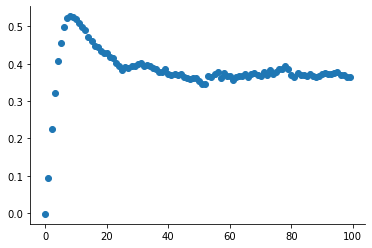

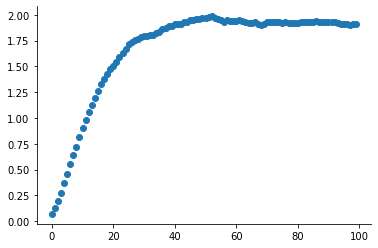

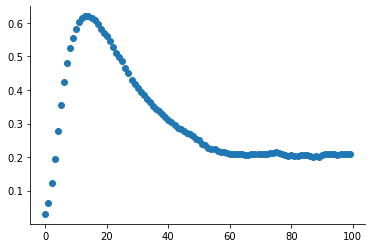

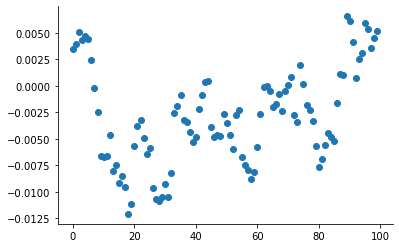

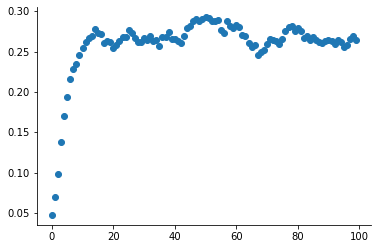

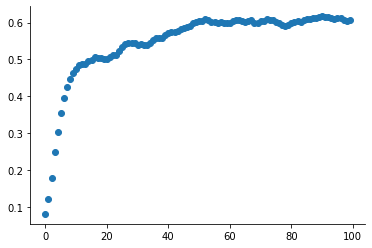

In [8]:
reservoir_average = np.mean(reservoir_states[:, :, :], axis=0)

for i in range(50):
    plt.scatter(
        range(100),
        reservoir_average[:, i],
    )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.show()